In [11]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import math
# Set seaborn style for better aesthetics
sns.set_style("whitegrid")

In [1]:
file_path_2023 = '2023data_copy.csv'
file_path_2024 = '2024data.csv'
m_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# Later We are callling these variables in Method1() function and Method2() function

## All the necessary functions are below here.

In [12]:
# Step 1: Load the data
def load_data(file_path):
    """
    Load the CSV data file into a pandas DataFrame.
    """
    # Read the CSV file
    data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    return data

# Step 2: Calculate daily returns
def calculate_daily_returns(data):
    """
    Calculate daily percentage returns for each stock and the index, with interpolation for missing values.
    """
    # Interpolate missing values in the data using linear interpolation
    data_interpolated = data.interpolate(method='linear', limit_direction='both')
    
    # Check if there are any remaining missing values, and fill if needed
    if data_interpolated.isnull().values.any():
        data_interpolated = data_interpolated.fillna(method='ffill').fillna(method='bfill')
    
    # Calculate daily percentage returns
    returns = data_interpolated.pct_change(fill_method=None)

    return returns

# Step 3: Calculate correlation matrix (ρ)
def calculate_correlation_matrix(returns):
    """
    Calculate the correlation matrix of stock returns.
    """
    # Calculate the correlation matrix
    correlation_matrix = returns.corr()
    return correlation_matrix

# Step 4: Formulate the Integer Programming model for stock selection
def optimize_stock_selection(correlation_matrix, m):
    """
    Formulate and solve the integer programming model for stock selection.
    """
    n = correlation_matrix.shape[0]  # Total number of stocks (n)
    
    # Initialize Gurobi model
    model = Model('Stock_Selection')
    model.Params.OutputFlag = 0  # Suppress output for clarity
    
    # Binary decision variables
    y = model.addVars(n, vtype=GRB.BINARY, name="y")  # Whether stock j is selected
    x = model.addVars(n, n, vtype=GRB.BINARY, name="x")  # Whether stock j represents stock i
    
    # Objective: Maximize total similarity (correlation)
    model.setObjective(quicksum(correlation_matrix.iloc[i, j] * x[i, j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    
    # Constraints
    # Select exactly m stocks
    model.addConstr(quicksum(y[j] for j in range(n)) == m, "select_m_stocks")
    
    # Each stock i must have exactly one representative stock j
    for i in range(n):
        model.addConstr(quicksum(x[i, j] for j in range(n)) == 1, f"represent_stock_{i}")
    
    # Stock j can represent stock i only if stock j is selected
    for i in range(n):
        for j in range(n):
            model.addConstr(x[i, j] <= y[j], f"represent_stock_if_selected_{i}_{j}")
    
    # Solve the model
    model.optimize()
    print(f"Optimal solution found with objective value {model.objVal}")
    
    # Extract selected stocks
    selected_stocks = [j for j in range(n) if y[j].x > 0.5]
    return selected_stocks, model.ObjVal

# Step 5: Formulate the Integer Programming model for optimal portfolio weights based on stock selection
def optimize_portfolio_weights(selected_stocks, returns, index_returns):
    """
    Formulate and solve the linear programming model to find optimal portfolio weights.
    """
    # Map the selected stock indices to actual stock tickers
    selected_stock_tickers = returns.columns[selected_stocks]
    
    m = len(selected_stocks)
    T = len(returns)
    
    # Subset of returns of selected stocks (use tickers, not indices)
    selected_returns = returns[selected_stock_tickers]
    
    # Initialize Gurobi model for weight optimization
    model = Model('Weight_Optimization')
    model.Params.OutputFlag = 0  # Suppress output for clarity
    
    # Variables: Weights of selected stocks
    w = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="w")  # Weights must be >= 0
    
    # Auxiliary variables for absolute differences (z_t >= |q_t - sum(w_i * r_it)|)
    z = model.addVars(T, vtype=GRB.CONTINUOUS, name="z")
    
    # Objective: Minimize the tracking error
    model.setObjective(quicksum(z[t] for t in range(T)), GRB.MINIMIZE)
    
    # Constraints
    # Each absolute deviation constraint
    for t in range(T):
        model.addConstr(quicksum(w[i] * selected_returns.iloc[t, i] for i in range(m)) - index_returns.iloc[t] <= z[t], f"abs_dev_pos_{t}")
        model.addConstr(index_returns.iloc[t] - quicksum(w[i] * selected_returns.iloc[t, i] for i in range(m)) <= z[t], f"abs_dev_neg_{t}")
    
    # Sum of weights must be equal to 1
    model.addConstr(quicksum(w[i] for i in range(m)) == 1, "sum_of_weights")
    
    # Solve the model
    model.optimize()
    
    # Extract portfolio weights and map them to stock tickers
    portfolio_weights = {selected_stock_tickers[i]: w[i].x for i in range(m)}
    return portfolio_weights, model

# Step 6: Evaluate Portfolio Performance (Tracking Error) ----------------------------------
def evaluate_portfolio_performance(portfolio_weights, returns, index_returns):
    """
    Evaluate the portfolio performance by calculating the tracking error and cumulative returns.
    """
    # Use stock tickers (keys of portfolio_weights) to select relevant columns
    portfolio_returns = returns[list(portfolio_weights.keys())].dot(list(portfolio_weights.values()))
    # print(f"Portfolio returns: {portfolio_returns}")
    
    # Calculate tracking error
    tracking_error = np.sum(np.abs(index_returns - portfolio_returns))
    # tracking_error = np.mean(np.abs(index_returns - portfolio_returns))
    
    # Calculate cumulative returns
    index_cum_returns = (1 + index_returns).cumprod() - 1
    portfolio_cum_returns = (1 + portfolio_returns).cumprod() - 1
    
    return tracking_error, portfolio_returns, index_cum_returns, portfolio_cum_returns

def plot_cumulative_returns(index_cum_returns_in, portfolio_cum_returns_in, index_cum_returns_out, portfolio_cum_returns_out, title):
    """
    Plot the cumulative returns of the index and the portfolio for both in-sample and out-of-sample.
    """
    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Plot the in-sample cumulative returns on the left subplot
    ax1.plot(index_cum_returns_in.index, index_cum_returns_in, label='Index Cumulative Returns (In-Sample)', linestyle='--')
    ax1.plot(portfolio_cum_returns_in.index, portfolio_cum_returns_in, label='Portfolio Cumulative Returns (In-Sample)', linestyle='--')
    ax1.set_title(f'In-Sample Cumulative Returns: {title}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Return')
    ax1.legend()
    ax1.grid(True)

    # Plot the out-of-sample cumulative returns on the right subplot
    ax2.plot(index_cum_returns_out.index, index_cum_returns_out, label='Index Cumulative Returns (Out-of-Sample)', linestyle='-')
    ax2.plot(portfolio_cum_returns_out.index, portfolio_cum_returns_out, label='Portfolio Cumulative Returns (Out-of-Sample)', linestyle='-')
    ax2.set_title(f'Out-of-Sample Cumulative Returns: {title}')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

def plot_tracking_error(index_returns_in, portfolio_returns_in, index_returns_out, portfolio_returns_out, title):
    """
    Plot the tracking error over time for both in-sample and out-of-sample.
    """
    # Calculate the absolute tracking error for in-sample and out-of-sample
    tracking_error_in = np.abs(index_returns_in - portfolio_returns_in)
    tracking_error_out = np.abs(index_returns_out - portfolio_returns_out)

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Plot the in-sample tracking error on the left subplot
    ax1.plot(tracking_error_in.index, tracking_error_in, label='Tracking Error (In-Sample)', linestyle='--', color='blue', linewidth=1.5)
    ax1.set_title(f'In-Sample Tracking Error: {title}', fontsize=14)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Absolute Tracking Error', fontsize=12)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

    # Plot the out-of-sample tracking error on the right subplot
    ax2.plot(tracking_error_out.index, tracking_error_out, label='Tracking Error (Out-of-Sample)', linestyle='-', color='red', linewidth=1.5)
    ax2.set_title(f'Out-of-Sample Tracking Error: {title}', fontsize=14)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

    # Adjust layout to prevent overlap and make it visually appealing
    plt.tight_layout(pad=2.0)
    plt.show()

def plot_tracking_error_vs_m(m_values, tracking_errors_in_sample, tracking_errors_out_of_sample):
    """
    Plot tracking error against different values of m for both in-sample and out-of-sample.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(m_values, tracking_errors_in_sample, marker='o', label='In-Sample Tracking Error', linestyle='--')
    plt.plot(m_values, tracking_errors_out_of_sample, marker='o', label='Out-of-Sample Tracking Error', linestyle='-')
    plt.title('Tracking Error vs. Number of Stocks Selected (m)')
    plt.xlabel('Number of Stocks Selected (m)')
    plt.ylabel('Total Tracking Error')
    plt.legend()
    plt.show()

#---------------------------------------------------------------------------------------------


In [ ]:
# Main function to run the optimization and plotting
def Method1(file_path_2023,file_path_2024,m_list):
    # Step 1: Load data

    data_2023 = load_data(file_path_2023)
    data_2024 = load_data(file_path_2024)

    #calculating the number of stocks in the data  
    num_stocks = len(data_2023.columns) - 1 # date and index stocks are not considered

    # Step 2: Calculate returns
    returns_2023 = calculate_daily_returns(data_2023)
    returns_2024 = calculate_daily_returns(data_2024)

    # to csv
    # returns_2023.to_csv('returns_2023.csv')
    # returns_2024.to_csv('returns_2024.csv')
    returns_2023 = returns_2023.fillna(0)
    returns_2024 = returns_2024.fillna(0)
    returns_2023 = returns_2023.replace([np.inf, -np.inf], 0)
    returns_2024 = returns_2024.replace([np.inf, -np.inf], 0)
  
    # Index returns
    index_returns_2023 = returns_2023.iloc[:, 0]  # Assuming the first column is the index (NDX)
    index_returns_2024 = returns_2024.iloc[:, 0]
    
    # Stock returns
    stock_returns_2023 = returns_2023.iloc[:, 1:]  # Remaining columns are stock returns
    stock_returns_2024 = returns_2024.iloc[:, 1:]


    # Calculate the correlation matrix (ρij)
    correlation_matrix = calculate_correlation_matrix(stock_returns_2023)
    
    # List to store tracking errors for different m values
    
    m_values = [x for x in m_list if x <= num_stocks]
    if num_stocks not in m_values and num_stocks <= 100:
        m_values.append(num_stocks)
        
    tracking_errors_in_sample = []
    tracking_errors_out_of_sample = []
    tracking_selected_stock_names = []
    tarcking_modelObjValue = []
    tracking_portfolio_weights = []
    
    for m in m_values:
        print(f"Processing for m = {m}")
        # Step 4: Optimize stock selection
        selected_stocks, modelObjValue = optimize_stock_selection(correlation_matrix, m)
        print(f"Stocks selected for m={m}: {selected_stocks}")
        selected_stock_names = stock_returns_2023.columns[selected_stocks]
        print(f"Selected Stocks for m={m}: {list(selected_stock_names)}")
        tracking_selected_stock_names.append(selected_stock_names)
        tarcking_modelObjValue.append(modelObjValue)
        
        # Step 5: Optimize portfolio weights using 2023 data
        portfolio_weights, _ = optimize_portfolio_weights(selected_stocks, stock_returns_2023, index_returns_2023)
        print(f"Portfolio weights claculated from In-Sample (2023) for m={m}: {portfolio_weights}")
        tracking_portfolio_weights.append(portfolio_weights)
        
        # Step 6: Evaluate performance on 2023 data (In-sample)
        tracking_error_in, portfolio_returns_in, index_cum_returns_in, portfolio_cum_returns_in = evaluate_portfolio_performance(
            portfolio_weights, stock_returns_2023, index_returns_2023)
        tracking_errors_in_sample.append(tracking_error_in)

        # Evaluate performance on 2024 data (Out-of-sample)
        # Ensure the selected stocks are present in 2024 data
        common_stocks = list(set(stock_returns_2024.columns).intersection(selected_stock_names))
        missing_stocks = set(selected_stock_names) - set(common_stocks)
        if missing_stocks:
            print(f"Warning: The following selected stocks are not present in 2024 data: {missing_stocks}")
            # Adjust weights for missing stocks
            adjusted_weights = {stock: weight for stock, weight in portfolio_weights.items() if stock in common_stocks}
            total_weight = sum(adjusted_weights.values())
            adjusted_weights = {k: v / total_weight for k, v in adjusted_weights.items()}
            print(f"Portfolio weights claculated from In-Sample (2023) for m={m}: {adjusted_weights} Adjusted for missing stocks")
        else:
            adjusted_weights = portfolio_weights
        
      
        tracking_error_out, portfolio_returns_out, index_cum_returns_out, portfolio_cum_returns_out = evaluate_portfolio_performance(
            adjusted_weights, stock_returns_2024, index_returns_2024)
        tracking_errors_out_of_sample.append(tracking_error_out)

        # Call the updated plotting functions for comparison
        plot_cumulative_returns(index_cum_returns_in, portfolio_cum_returns_in, index_cum_returns_out, portfolio_cum_returns_out, f"m={m}")

        plot_tracking_error(index_returns_2023, portfolio_returns_in, index_returns_2024, portfolio_returns_out, f"m={m}")
    
    # Plot tracking error vs m (comparison between in-sample and out-of-sample)
    plot_tracking_error_vs_m(m_values, tracking_errors_in_sample, tracking_errors_out_of_sample)
    
    
    # Create a DataFrame to summarize the tracking errors
    tracking_df = pd.DataFrame({
        'm': m_values,
        'Objective Value' : tarcking_modelObjValue,
        'Selected Portfolio Stocks' : tracking_selected_stock_names,
        'Selected Portfolio Weights': tracking_portfolio_weights,
        'In-Sample Tracking Error': tracking_errors_in_sample,
        'Out-of-Sample Tracking Error': tracking_errors_out_of_sample
    })
    # print only m, in-sample tracking error, out-of-sample tracking error only print
    tracking_error_df = tracking_df[['m', 'In-Sample Tracking Error', 'Out-of-Sample Tracking Error']]
    print(tracking_error_df)
    
    # Optional: Save the tracking error DataFrame to a CSV file
    tracking_df.to_csv('tracking_df_lp.csv', index=False)

    return tracking_errors_out_of_sample



/var/folders/f_/761zdxqd4xj6cs5ww2w054x40000gn/T/ipykernel_71928/78728224.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
/var/folders/f_/761zdxqd4xj6cs5ww2w054x40000gn/T/ipykernel_71928/78728224.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file_path, index_col='Date', parse_dates=True)


Processing for m = 5
Optimal solution found with objective value 51.44502840905931
Stocks selected for m=5: [47, 51, 72, 81, 88]
Selected Stocks for m=5: ['HON', 'INTU', 'NXPI', 'PEP', 'SNPS']
Portfolio weights claculated from In-Sample (2023) for m=5: {'HON': 0.13532789738415604, 'INTU': 0.22717045376089487, 'NXPI': 0.1719438705236885, 'PEP': 0.21077735222976027, 'SNPS': 0.2547804261015003}


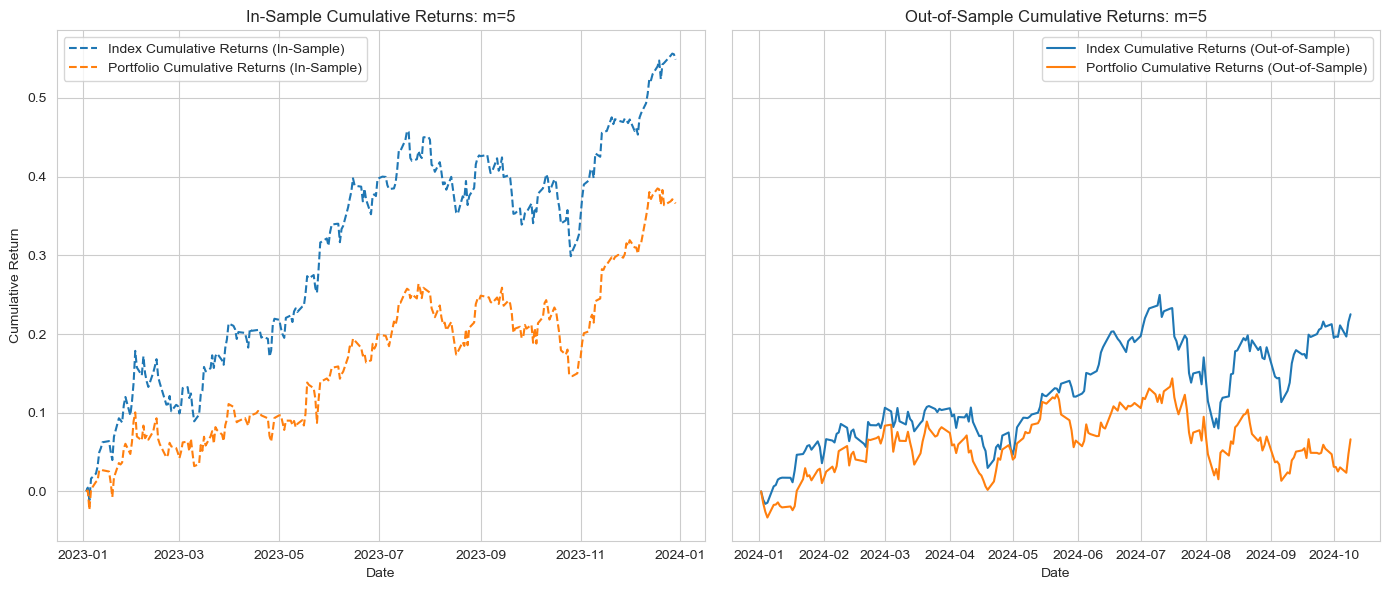

Processing for m = 10
Optimal solution found with objective value 57.334557980761915
Stocks selected for m=10: [4, 5, 17, 33, 45, 47, 48, 72, 81, 88]
Selected Stocks for m=10: ['AMZN', 'AEP', 'BKR', 'CRWD', 'GILD', 'HON', 'IDXX', 'NXPI', 'PEP', 'SNPS']
Portfolio weights claculated from In-Sample (2023) for m=10: {'AMZN': 0.2372899696225989, 'AEP': 0.02919944613092518, 'BKR': 0.02652856862185047, 'CRWD': 0.04057024356894146, 'GILD': 0.0613169452950048, 'HON': 0.047410872663915284, 'IDXX': 0.03932054758763046, 'NXPI': 0.1593360545716206, 'PEP': 0.16522859746633933, 'SNPS': 0.1937987544711734}


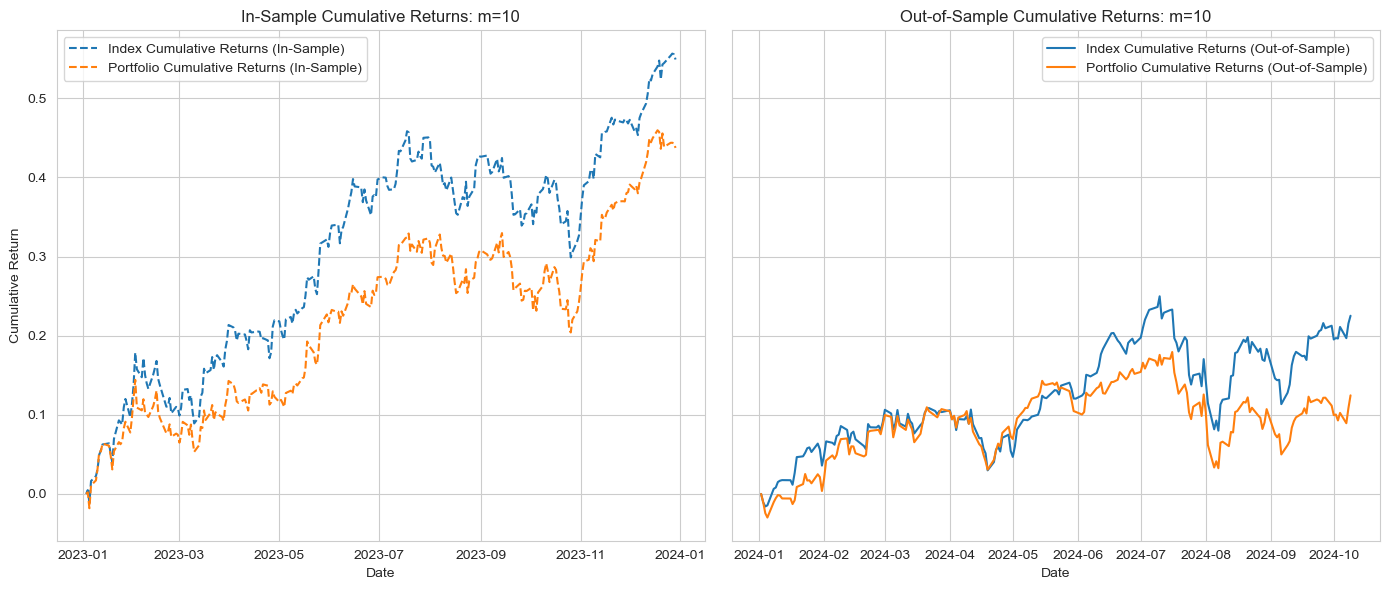

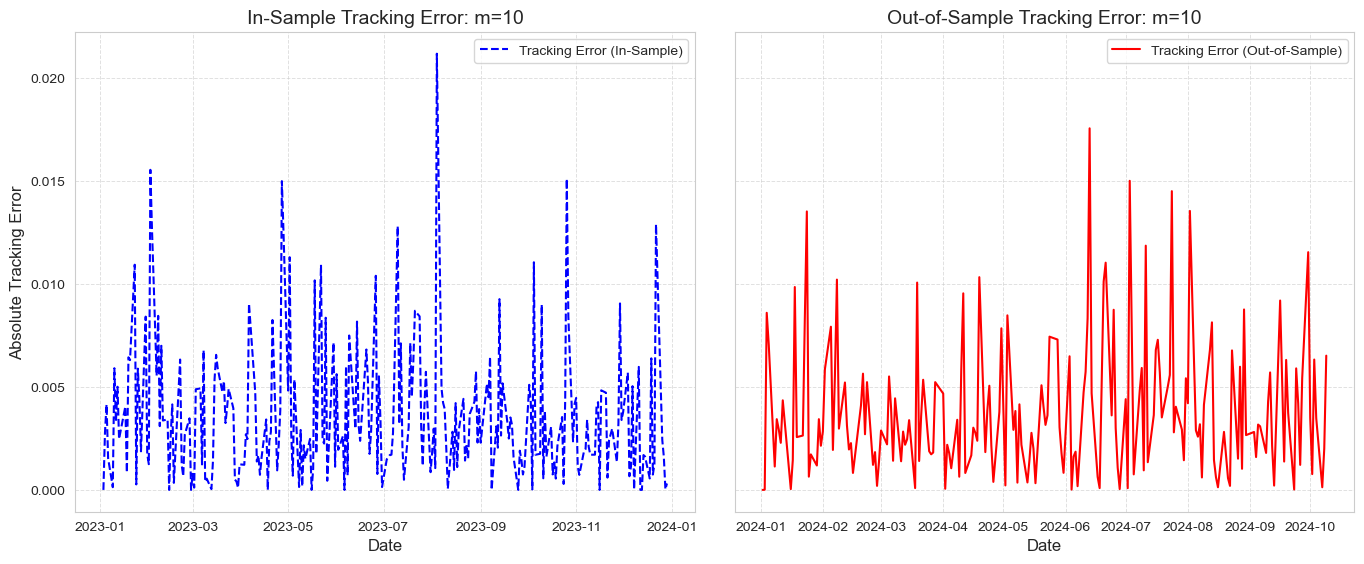

Processing for m = 20
Optimal solution found with objective value 65.18792551756204
Stocks selected for m=20: [2, 4, 5, 10, 11, 13, 16, 17, 23, 33, 36, 45, 47, 48, 66, 72, 81, 85, 88, 89]
Selected Stocks for m=20: ['ABNB', 'AMZN', 'AEP', 'AMAT', 'ARM', 'AZN', 'ADP', 'BKR', 'CHTR', 'CRWD', 'DXCM', 'GILD', 'HON', 'IDXX', 'MRNA', 'NXPI', 'PEP', 'ROST', 'SNPS', 'TTWO']
Portfolio weights claculated from In-Sample (2023) for m=20: {'ABNB': 0.008131592005950596, 'AMZN': 0.22475927310262697, 'AEP': 0.018738141242689903, 'AMAT': 0.07622101106039138, 'ARM': 0.014673399635664981, 'AZN': 0.02825164650867674, 'ADP': 0.02459425390075354, 'BKR': 0.0144319211324902, 'CHTR': 0.040498997093154986, 'CRWD': 0.035149320380339084, 'DXCM': 0.0, 'GILD': 0.029561218250581077, 'HON': 0.02846498781898, 'IDXX': 0.03004288204360581, 'MRNA': 0.0170431378325204, 'NXPI': 0.07381269219844247, 'PEP': 0.09934134772389638, 'ROST': 0.028859948388599392, 'SNPS': 0.15094210470372182, 'TTWO': 0.05648212497691422}


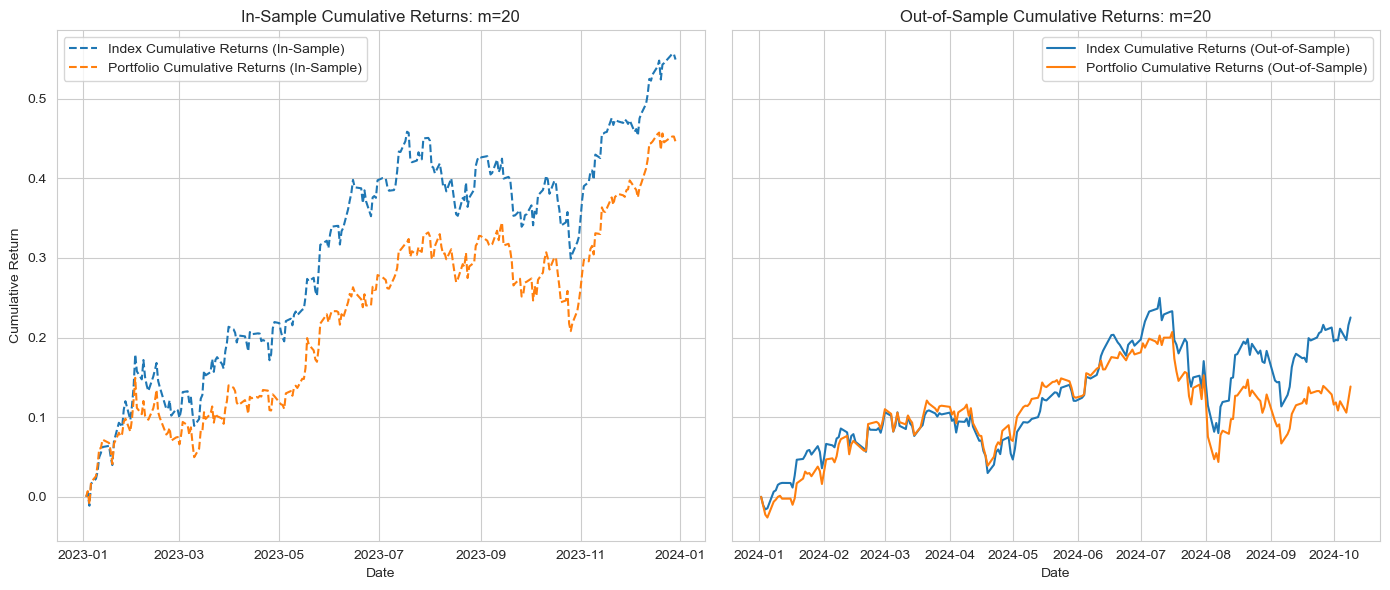

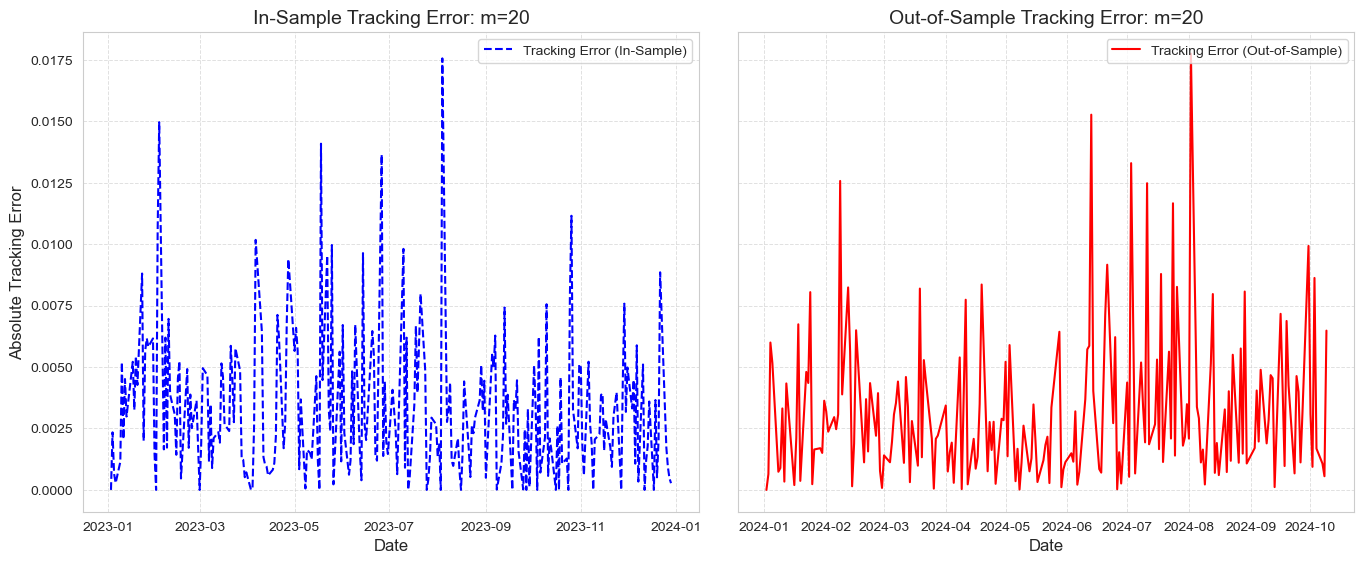

Processing for m = 30
Optimal solution found with objective value 71.484964789689
Stocks selected for m=30: [4, 5, 10, 11, 13, 16, 17, 19, 23, 25, 29, 33, 35, 36, 38, 40, 45, 47, 48, 58, 66, 70, 72, 73, 80, 81, 85, 88, 90, 93]
Selected Stocks for m=30: ['AMZN', 'AEP', 'AMAT', 'ARM', 'AZN', 'ADP', 'BKR', 'BKNG', 'CHTR', 'CSCO', 'CEG', 'CRWD', 'DDOG', 'DXCM', 'DLTR', 'EA', 'GILD', 'HON', 'IDXX', 'LULU', 'MRNA', 'NFLX', 'NXPI', 'ORLY', 'PDD', 'PEP', 'ROST', 'SNPS', 'TMUS', 'TTD']
Portfolio weights claculated from In-Sample (2023) for m=30: {'AMZN': 0.17597631019844526, 'AEP': 0.04505929793986486, 'AMAT': 0.07650649022101991, 'ARM': 0.007304738970778522, 'AZN': 0.0, 'ADP': 0.0470624889527282, 'BKR': 0.0, 'BKNG': 0.06611934288489052, 'CHTR': 0.02665528347930052, 'CSCO': 0.025151450250273315, 'CEG': 0.005368815187714401, 'CRWD': 0.024219702815181047, 'DDOG': 0.0014406398186103707, 'DXCM': 0.0, 'DLTR': 0.0, 'EA': 0.040109777684056415, 'GILD': 0.017275605157071574, 'HON': 0.015295110358894295,

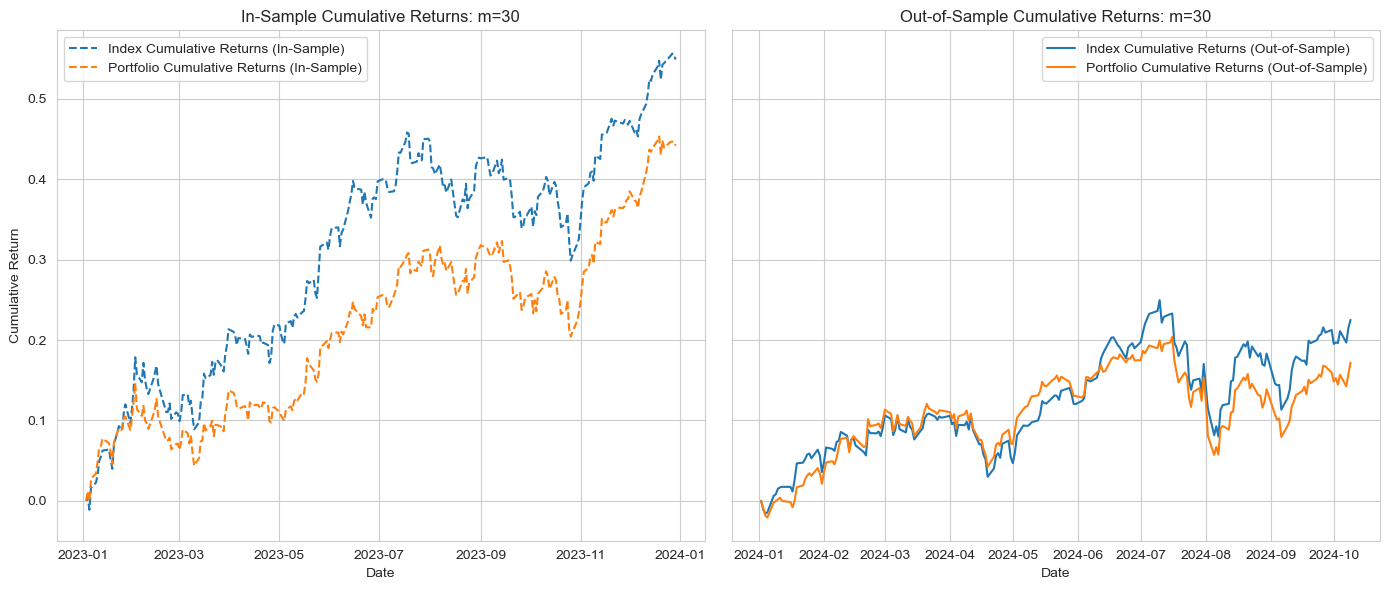

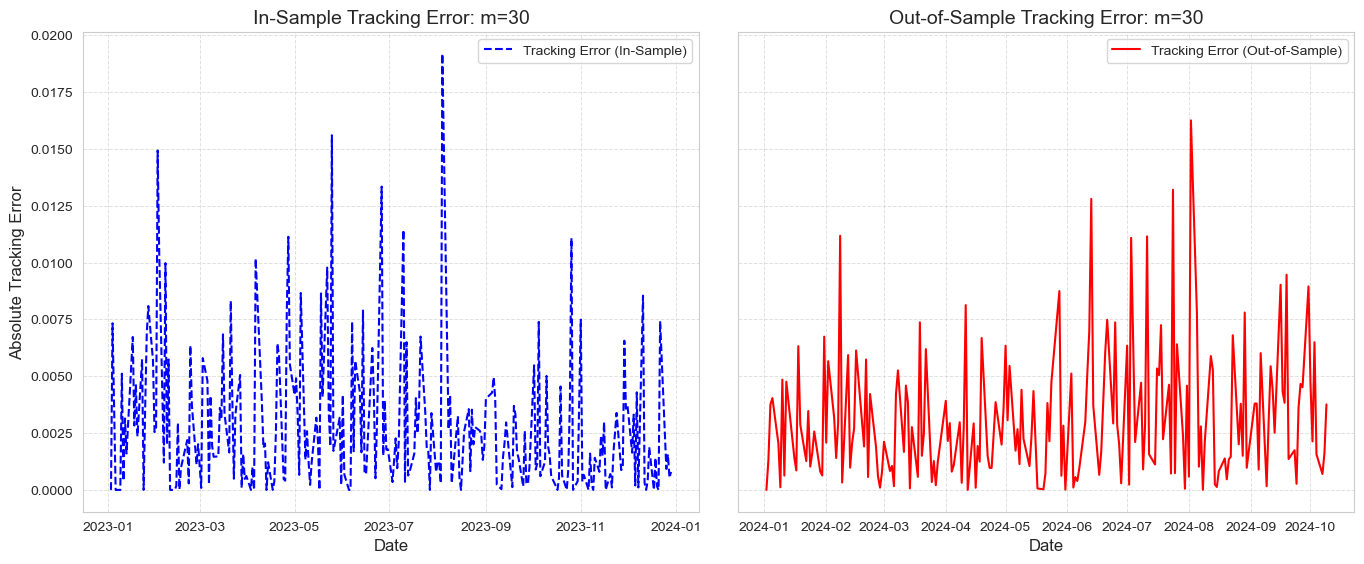

Processing for m = 40
Optimal solution found with objective value 77.23747106931941
Stocks selected for m=40: [5, 11, 13, 19, 21, 23, 24, 25, 29, 32, 33, 37, 38, 40, 43, 44, 45, 47, 49, 52, 56, 58, 61, 62, 66, 68, 70, 72, 73, 74, 78, 79, 80, 81, 85, 86, 87, 90, 93, 95]
Selected Stocks for m=40: ['AEP', 'ARM', 'AZN', 'BKNG', 'CDNS', 'CHTR', 'CTAS', 'CSCO', 'CEG', 'COST', 'CRWD', 'FANG', 'DLTR', 'EA', 'FTNT', 'GEHC', 'GILD', 'HON', 'ILMN', 'ISRG', 'LRCX', 'LULU', 'MELI', 'META', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PAYX', 'PYPL', 'PDD', 'PEP', 'ROST', 'SBUX', 'SMCI', 'TMUS', 'TTD', 'VRTX']
Portfolio weights claculated from In-Sample (2023) for m=40: {'AEP': 0.0, 'ARM': 0.005027414889170011, 'AZN': 0.012601524587012759, 'BKNG': 0.03337556979261632, 'CDNS': 0.10506365793888045, 'CHTR': 0.0, 'CTAS': 0.008214825494695868, 'CSCO': 0.03883908161031358, 'CEG': 0.031364222739556503, 'COST': 0.06958008259889935, 'CRWD': 0.018863209509856, 'FANG': 0.0, 'DLTR': 0.0, 'EA': 0.0284404770516

Processing for m = 50
Optimal solution found with objective value 82.64324611466914
Stocks selected for m=50: [4, 5, 6, 9, 11, 13, 16, 17, 18, 21, 22, 23, 24, 27, 29, 31, 32, 33, 34, 38, 42, 43, 44, 49, 52, 56, 57, 58, 59, 61, 66, 68, 70, 72, 73, 74, 76, 79, 80, 81, 83, 85, 86, 87, 89, 90, 91, 93, 95, 96]
Selected Stocks for m=50: ['AMZN', 'AEP', 'AMGN', 'AAPL', 'ARM', 'AZN', 'ADP', 'BKR', 'BIIB', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DLTR', 'FAST', 'FTNT', 'GEHC', 'ILMN', 'ISRG', 'LRCX', 'LIN', 'LULU', 'MAR', 'MELI', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRTX', 'WBD']
Portfolio weights claculated from In-Sample (2023) for m=50: {'AMZN': 0.13934733171722571, 'AEP': 0.0, 'AMGN': 0.010300256666976227, 'AAPL': 0.19422753880104482, 'ARM': 0.013119827549653688, 'AZN': 0.0, 'ADP': 0.01879627654923766, 'BKR': 0.0, 'BIIB': 0.025019448356131225, 'CDNS': 

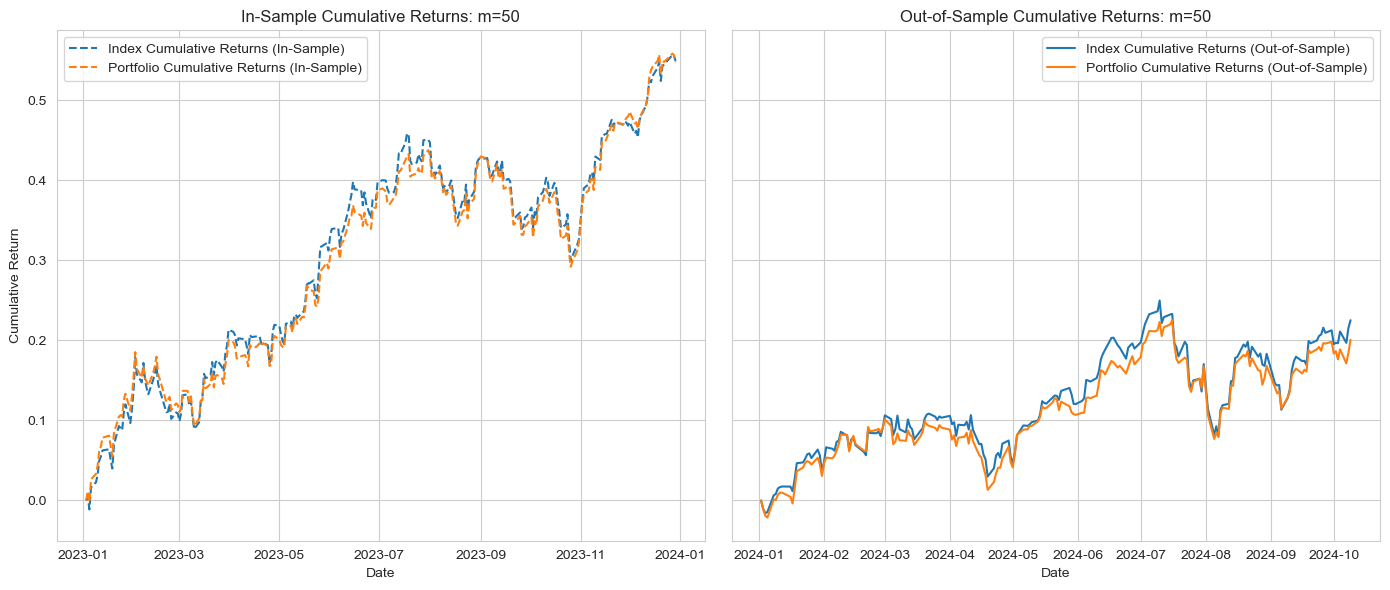

Processing for m = 60
Optimal solution found with objective value 87.47328209378213
Stocks selected for m=60: [2, 4, 5, 6, 8, 9, 11, 13, 15, 16, 17, 18, 22, 23, 24, 25, 27, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 48, 49, 50, 52, 56, 57, 58, 59, 61, 66, 70, 72, 73, 74, 76, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96]
Selected Stocks for m=60: ['ABNB', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'ADSK', 'ADP', 'BKR', 'BIIB', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'IDXX', 'ILMN', 'INTC', 'ISRG', 'LRCX', 'LIN', 'LULU', 'MAR', 'MELI', 'MRNA', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'VRSK', 'VRTX', 'WBD']
Portfolio weights claculated from In-Sample (2023) for m=60: {'ABNB': 0.0061016899910558775, 'AMZN': 0.12404078120563691, 'AEP': 0.0, 'AMGN': 0.013014145489186637,

Processing for m = 70
Optimal solution found with objective value 91.73092610546931
Stocks selected for m=70: [2, 3, 5, 6, 8, 9, 11, 13, 14, 15, 16, 18, 19, 22, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 61, 64, 65, 66, 68, 70, 72, 73, 74, 76, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97]
Selected Stocks for m=70: ['ABNB', 'GOOGL', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BIIB', 'BKNG', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'LIN', 'LULU', 'MAR', 'MELI', 'MU', 'MSFT', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY']
Portfolio weights claculated from In-Sample (20

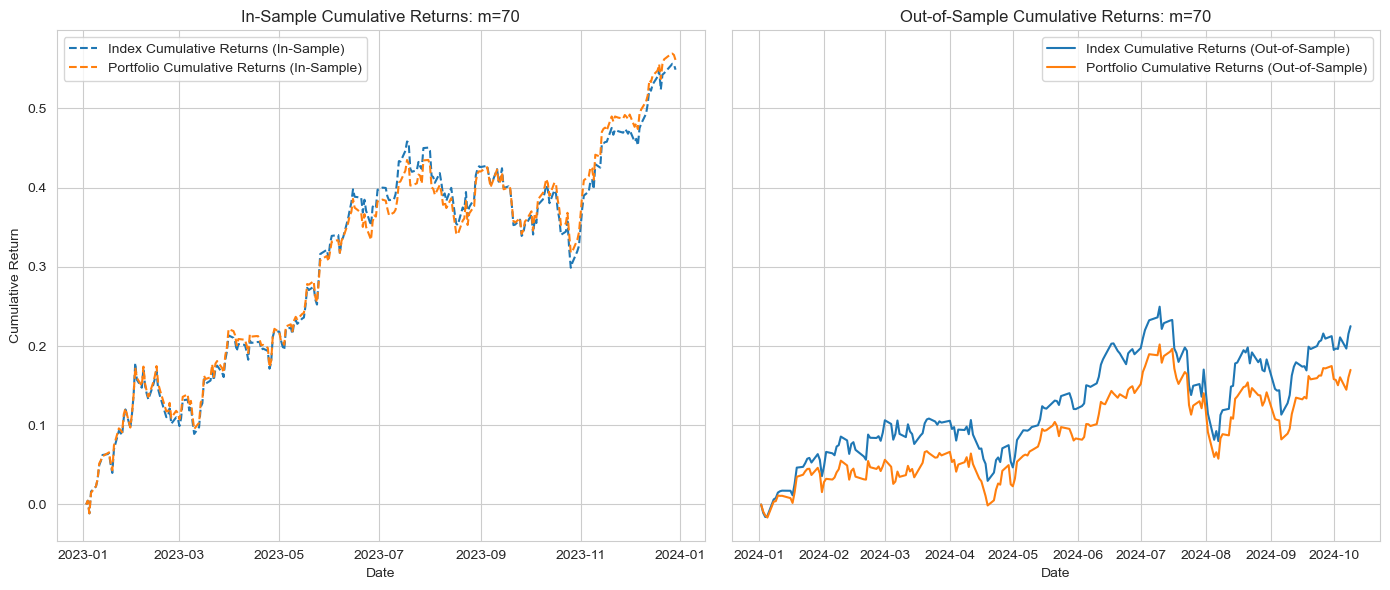

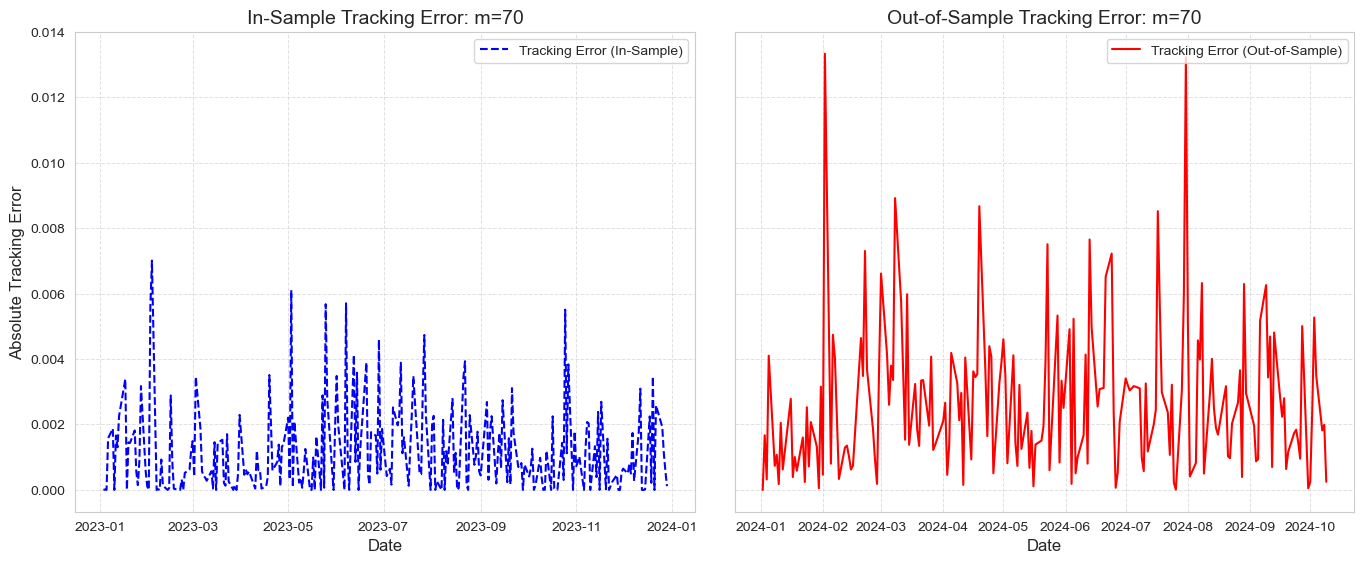

Processing for m = 80
Optimal solution found with objective value 95.47861265589168
Stocks selected for m=80: [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 31, 32, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 61, 62, 64, 65, 66, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 99]
Selected Stocks for m=80: ['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CEG', 'CSGP', 'COST', 'CSX', 'DDOG', 'DXCM', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR', 'MELI', 'META', 'MU', 'MSFT', 'MRNA', 'MNST', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'T

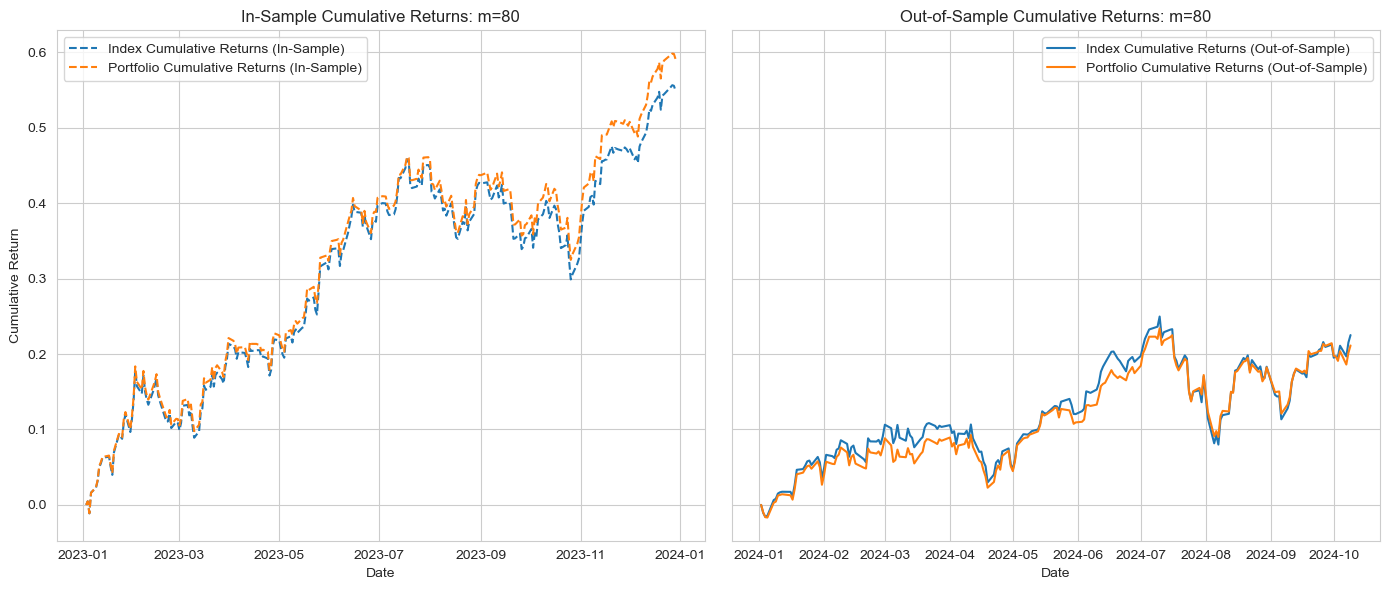

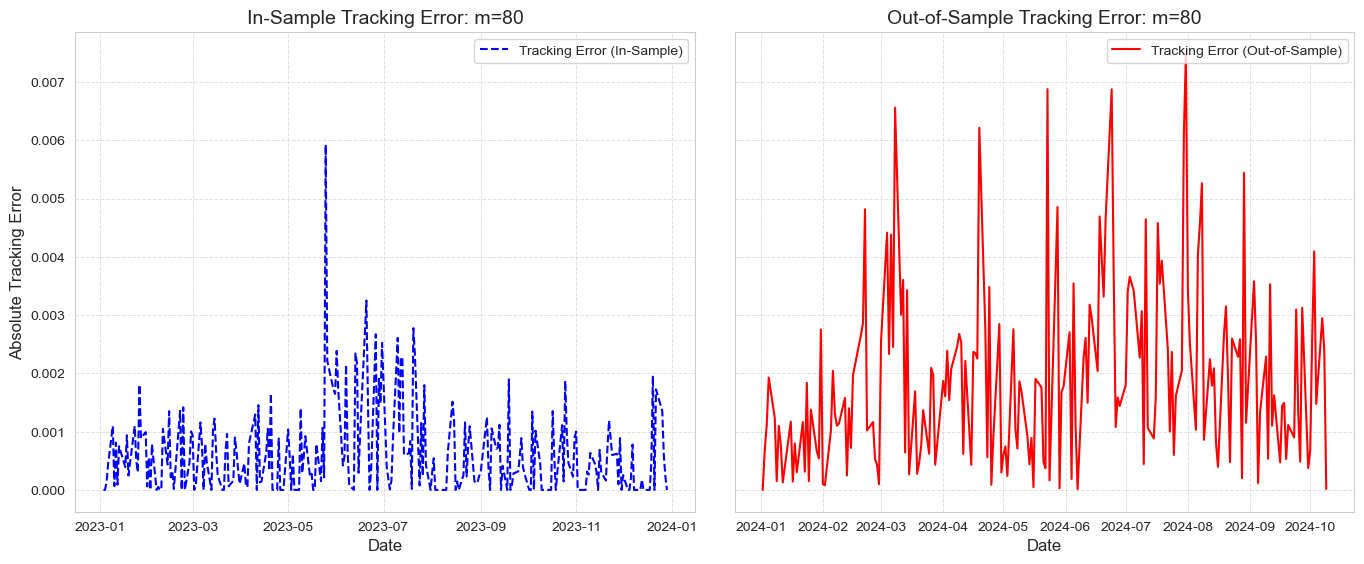

Processing for m = 90
Optimal solution found with objective value 98.38398204748015
Stocks selected for m=90: [0, 1, 2, 3, 4, 6, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]
Selected Stocks for m=90: ['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 

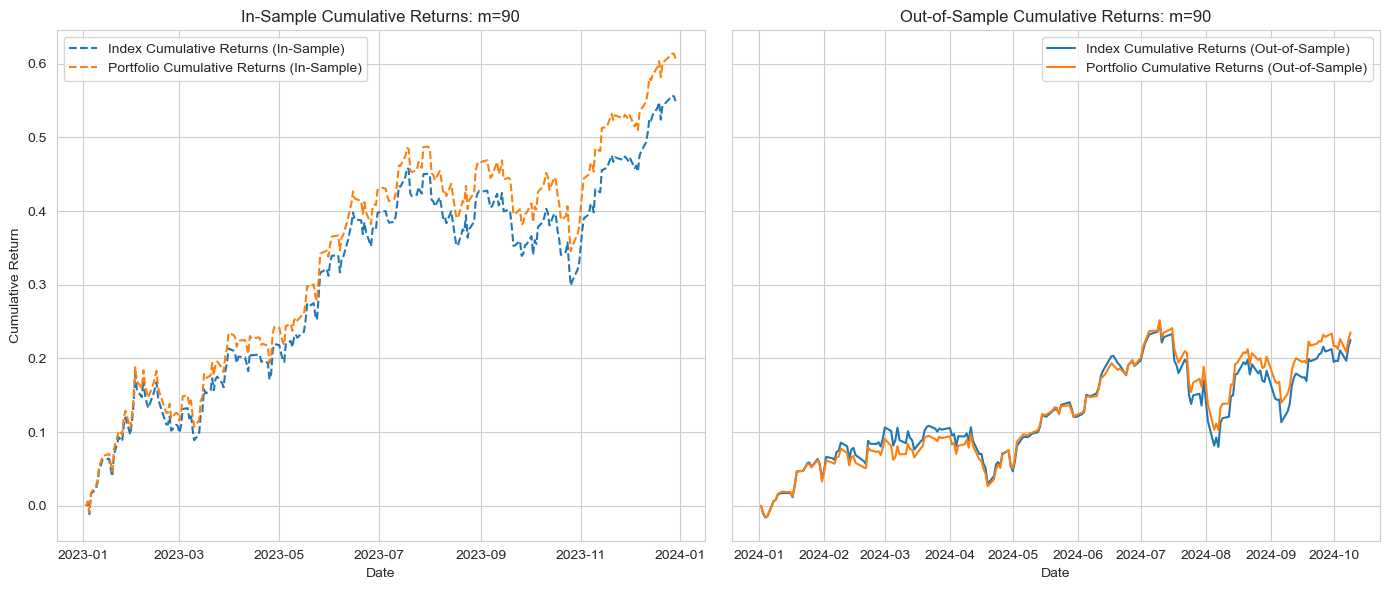

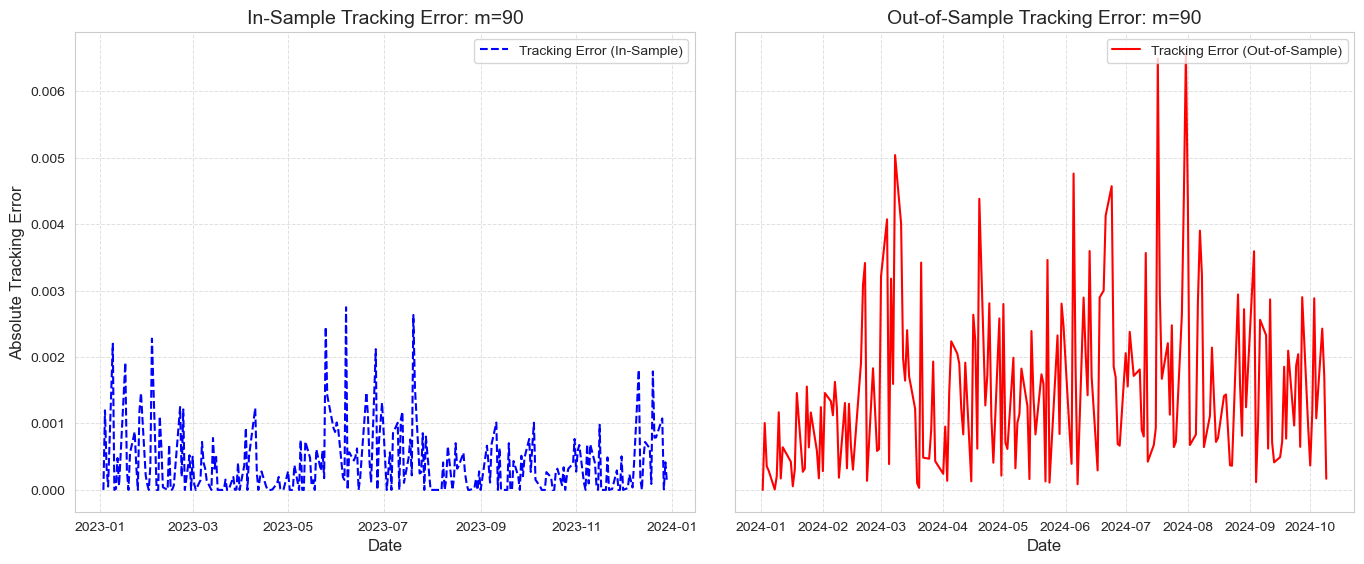

Processing for m = 100
Optimal solution found with objective value 100.0
Stocks selected for m=100: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Selected Stocks for m=100: ['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'M

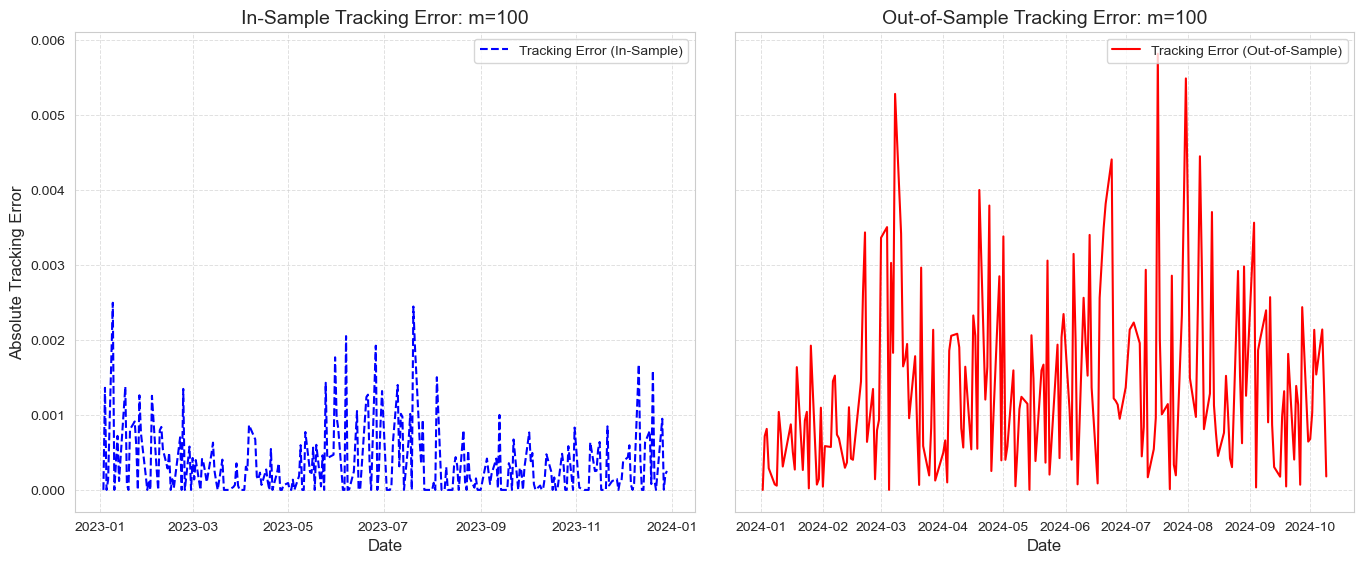

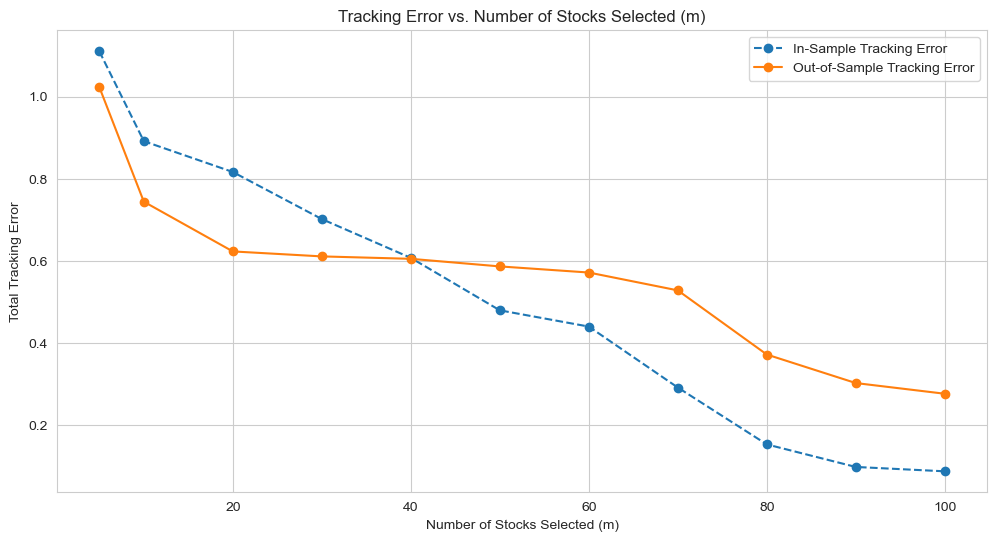

      m  In-Sample Tracking Error  Out-of-Sample Tracking Error
0     5                  1.110995                      1.023837
1    10                  0.892112                      0.744749
2    20                  0.817061                      0.623650
3    30                  0.702424                      0.611526
4    40                  0.607945                      0.605632
5    50                  0.480194                      0.587149
6    60                  0.440605                      0.572251
7    70                  0.292181                      0.528777
8    80                  0.153673                      0.372533
9    90                  0.098739                      0.303066
10  100                  0.088113                      0.277031


In [ ]:
method_1_tracking_errors_out_of_sample = Method1(file_path_2023,file_path_2024,m_list)

# ***MLP Method 2 using BIG M***

In [15]:
# Constants
TIME_LIMIT = 3600  # Time limit in seconds for Gurobi (1 hour)
BIG_M = 1.0  # Use a large constant for the "Big M" technique

# Step 3: Reformulated MIP for Stock Selection and Weights
def optimize_portfolio_with_MIP(returns, index_returns, m):
    """Formulate and solve the MIP to find portfolio weights with exactly m non-zero weights."""
    n = returns.shape[1]
    T = returns.shape[0]
    
    # Initialize Gurobi model
    model = Model('MIP_Weight_Optimization')
    model.Params.OutputFlag = 0  # Suppress output
    model.Params.TimeLimit = TIME_LIMIT  # Set time limit for Gurobi
    
    # Variables: Weights and binary decision variables
    w = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, name="w")  # Portfolio weights
    y = model.addVars(n, vtype=GRB.BINARY, name="y")  # Binary variables for stock selection
    z = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="z")  # Tracking error variables
    
    # Objective: Minimize the tracking error
    model.setObjective(quicksum(z[t] for t in range(T)), GRB.MINIMIZE)
    
    # Constraints
    for t in range(T):
        model.addConstr(quicksum(w[i] * returns.iloc[t, i] for i in range(n)) - index_returns.iloc[t] <= z[t])
        model.addConstr(index_returns.iloc[t] - quicksum(w[i] * returns.iloc[t, i] for i in range(n)) <= z[t])
    
    # Sum of weights must equal 1
    model.addConstr(quicksum(w[i] for i in range(n)) == 1, "sum_of_weights")
    
    # Limit the number of non-zero weights to exactly m
    model.addConstr(quicksum(y[i] for i in range(n)) == m, "select_m_stocks")
    
    # Ensure that w_i = 0 if y_i = 0 (Big M method)
    for i in range(n):
        model.addConstr(w[i] <= y[i] * BIG_M, f"big_M_constraint_{i}")
    
    # Solve the model
    model.optimize()
    
    if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
        # Extract portfolio weights
        portfolio_weights = {returns.columns[i]: w[i].x for i in range(n) if w[i].x > 0.001}
        selected_stocks = [returns.columns[i] for i in range(n) if y[i].x > 0.5]
        return portfolio_weights, selected_stocks, model.ObjVal
    else:
        raise ValueError("Gurobi was unable to find a solution within the time limit.")


In [ ]:
# Main function
def Method2(file_path_2023,file_path_2024,m_list):
    # Load data for 2023 and 2024

    data_2023 = load_data(file_path_2023)
    data_2024 = load_data(file_path_2024)

    #calculating the number of stocks in the data  
    num_stocks = len(data_2023.columns) - 1 # date and index stocks are not considered
    
    returns_2023 = calculate_daily_returns(data_2023)
    returns_2024 = calculate_daily_returns(data_2024)
    returns_2023 = returns_2023.fillna(0)
    returns_2024 = returns_2024.fillna(0)
    returns_2023 = returns_2023.replace([np.inf, -np.inf], 0)
    returns_2024 = returns_2024.replace([np.inf, -np.inf], 0)


    index_returns_2023 = returns_2023.iloc[:, 0]
    index_returns_2024 = returns_2024.iloc[:, 0]
    stock_returns_2023 = returns_2023.iloc[:, 1:]
    stock_returns_2024 = returns_2024.iloc[:, 1:]
    
    # List to store tracking errors for different m values

    m_values = [x for x in m_list if x <= num_stocks]
    if num_stocks not in m_values and num_stocks <= 100:
        m_values.append(num_stocks)
        
    tracking_errors_in_sample = []
    tracking_errors_out_of_sample = []
    tracking_selected_stock_names = []
    tarcking_modelObjValue = []
    tracking_portfolio_weights = []
    
    for m in m_values:
        print(f"Processing for m = {m}")
        
        # Solve MIP for portfolio weights with m non-zero weights
        portfolio_weights,selected_stocks_name, modelObjValue = optimize_portfolio_with_MIP(stock_returns_2023, index_returns_2023, m)
        tracking_selected_stock_names.append(selected_stocks_name)
        tarcking_modelObjValue.append(modelObjValue)
        tracking_portfolio_weights.append(portfolio_weights)
        
        # Evaluate performance on 2023 data (in-sample)
        tracking_error_in, portfolio_returns_in, index_cum_returns_in, portfolio_cum_returns_in = evaluate_portfolio_performance(
            portfolio_weights, stock_returns_2023, index_returns_2023)
        tracking_errors_in_sample.append(tracking_error_in)
        
        # Evaluate performance on 2024 data (out-of-sample)
        tracking_error_out, portfolio_returns_out, index_cum_returns_out, portfolio_cum_returns_out = evaluate_portfolio_performance(
            portfolio_weights, stock_returns_2024, index_returns_2024)
        tracking_errors_out_of_sample.append(tracking_error_out)
        
        # Plot portfolio performance and error
        plot_cumulative_returns(index_cum_returns_in, portfolio_cum_returns_in, index_cum_returns_out, portfolio_cum_returns_out, f"m={m}")

        plot_tracking_error(index_returns_2023, portfolio_returns_in, index_returns_2024, portfolio_returns_out, f"m={m}")


    # Plot tracking error vs m (comparison between in-sample and out-of-sample)
    plot_tracking_error_vs_m(m_values, tracking_errors_in_sample, tracking_errors_out_of_sample)
    
    tracking_df_mlp = pd.DataFrame({
        'm': m_values,
        'Objective Value' : tarcking_modelObjValue,
        'Selected Portfolio Stocks' : tracking_selected_stock_names,
        'Selected Portfolio Weights': tracking_portfolio_weights,
        'In-Sample Tracking Error': tracking_errors_in_sample,
        'Out-of-Sample Tracking Error': tracking_errors_out_of_sample
    })
    # Print the tracking error DataFrame
    tracking_error_df_mlp = tracking_df_mlp[['m', 'In-Sample Tracking Error', 'Out-of-Sample Tracking Error']]
    print(tracking_error_df_mlp)

    # Optional: Save the tracking error DataFrame to a CSV file
    tracking_df_mlp.to_csv('tracking_df_mlp.csv', index=False)

    return tracking_errors_out_of_sample


Processing for m = 5


/var/folders/f_/761zdxqd4xj6cs5ww2w054x40000gn/T/ipykernel_71928/78728224.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
/var/folders/f_/761zdxqd4xj6cs5ww2w054x40000gn/T/ipykernel_71928/78728224.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file_path, index_col='Date', parse_dates=True)


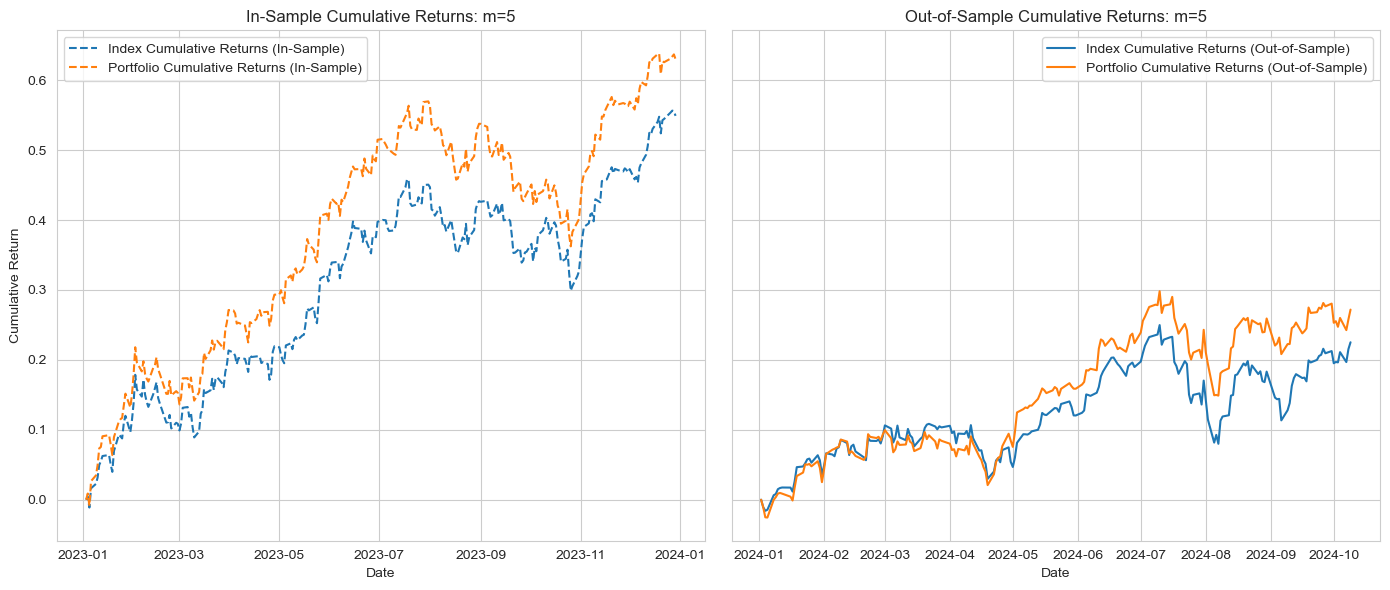

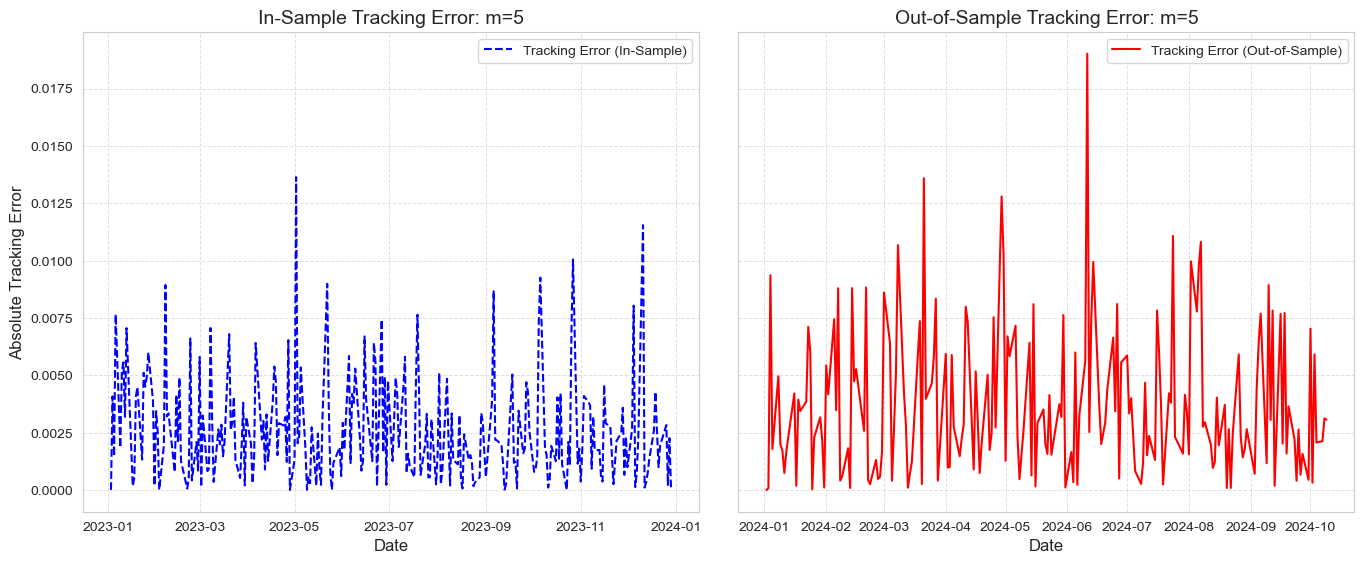

Processing for m = 10


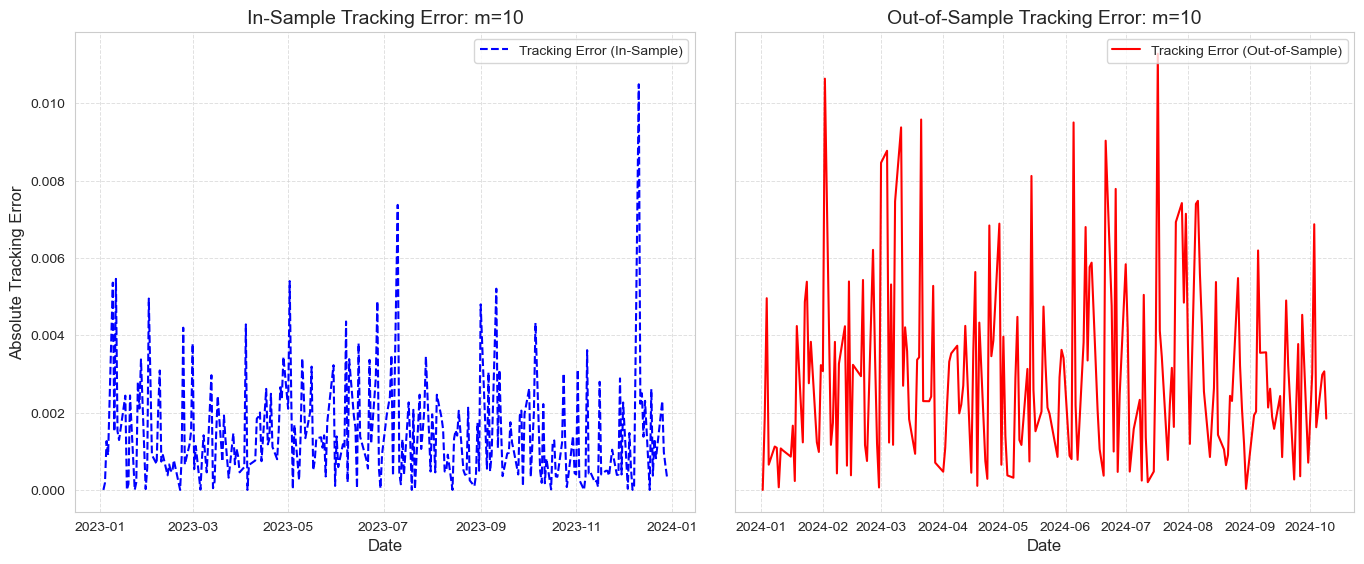

Processing for m = 20


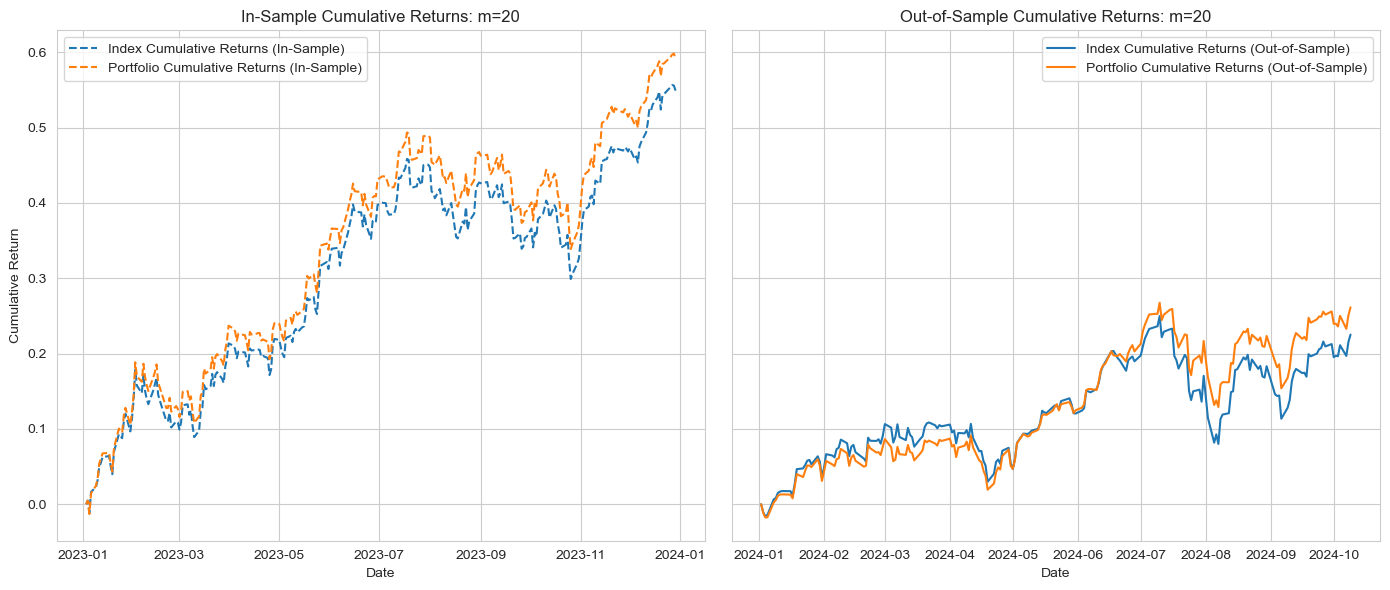

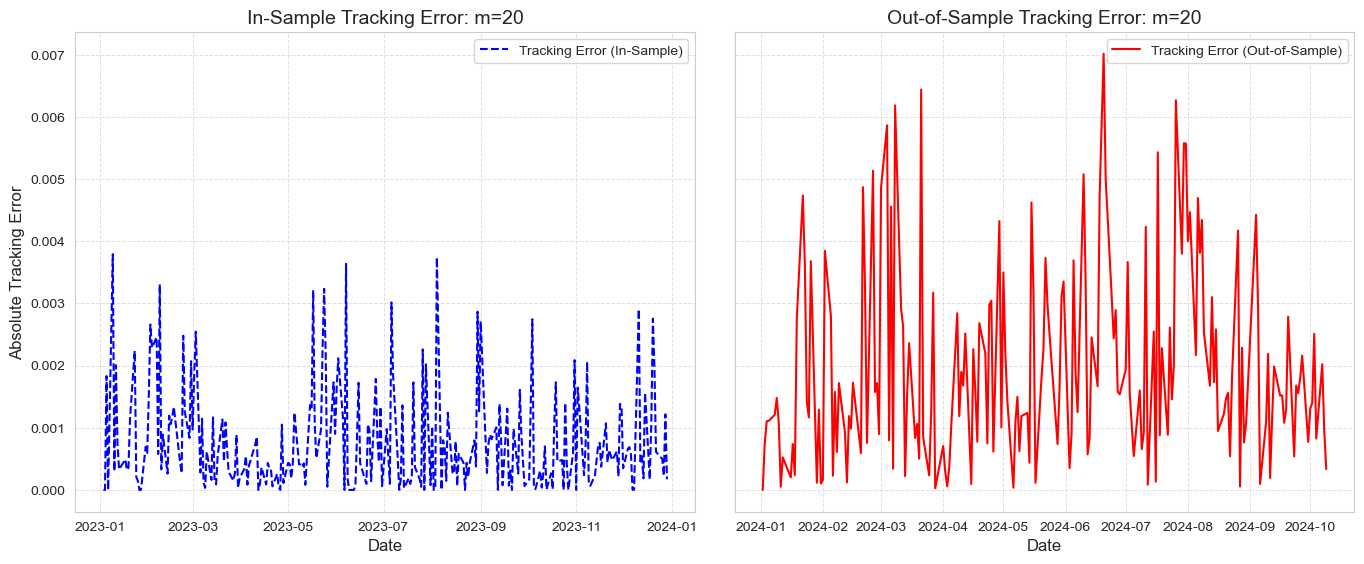

Processing for m = 30


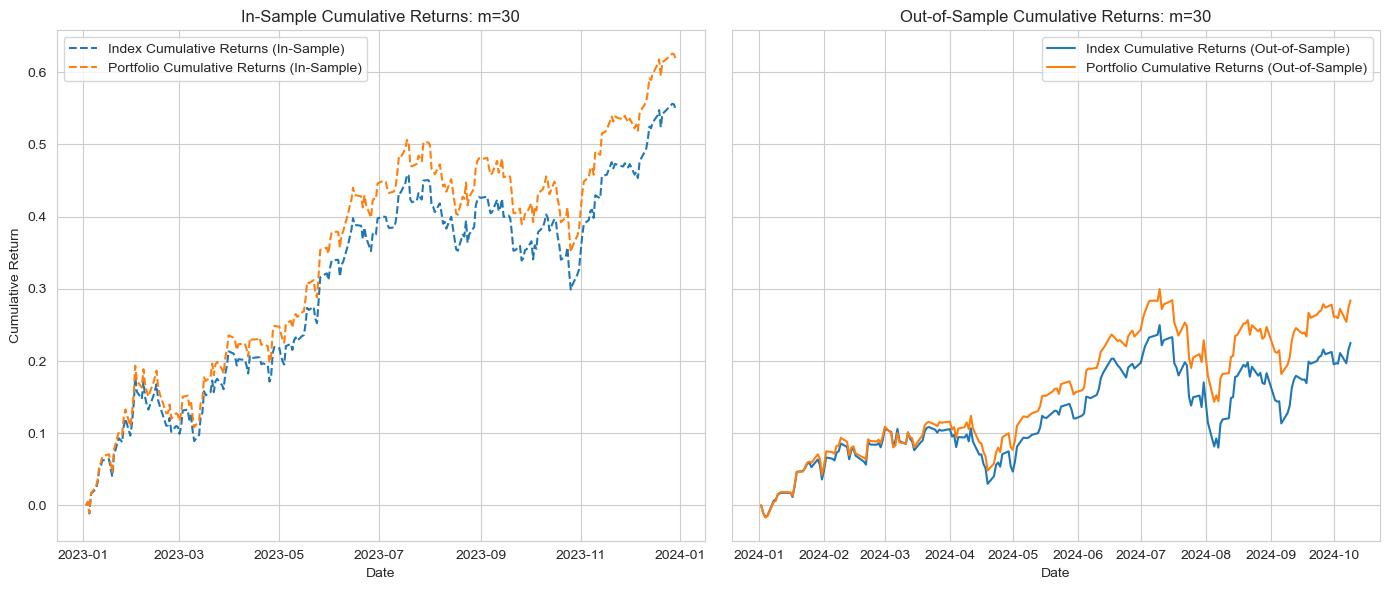

Processing for m = 40


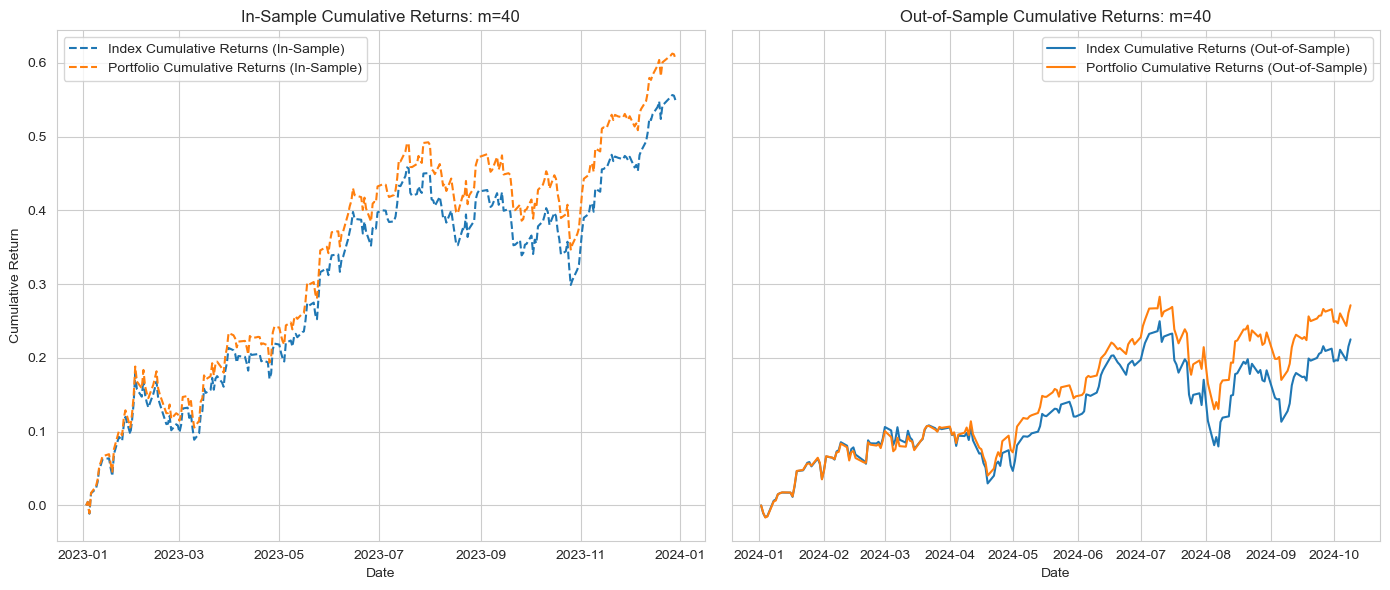

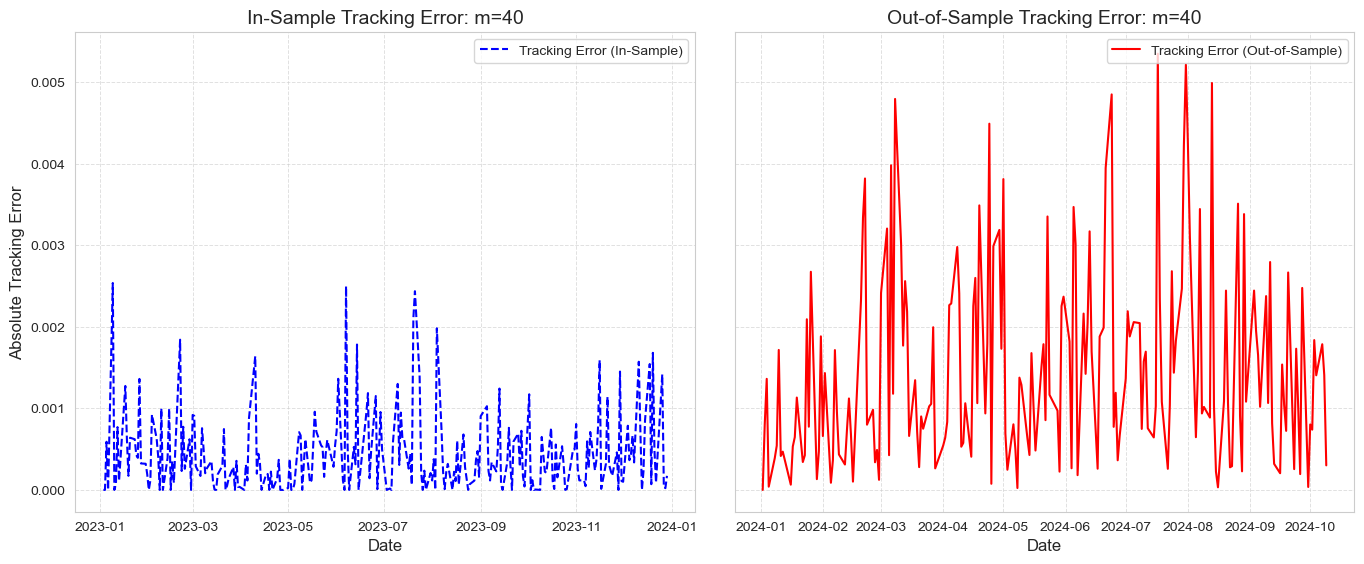

Processing for m = 50


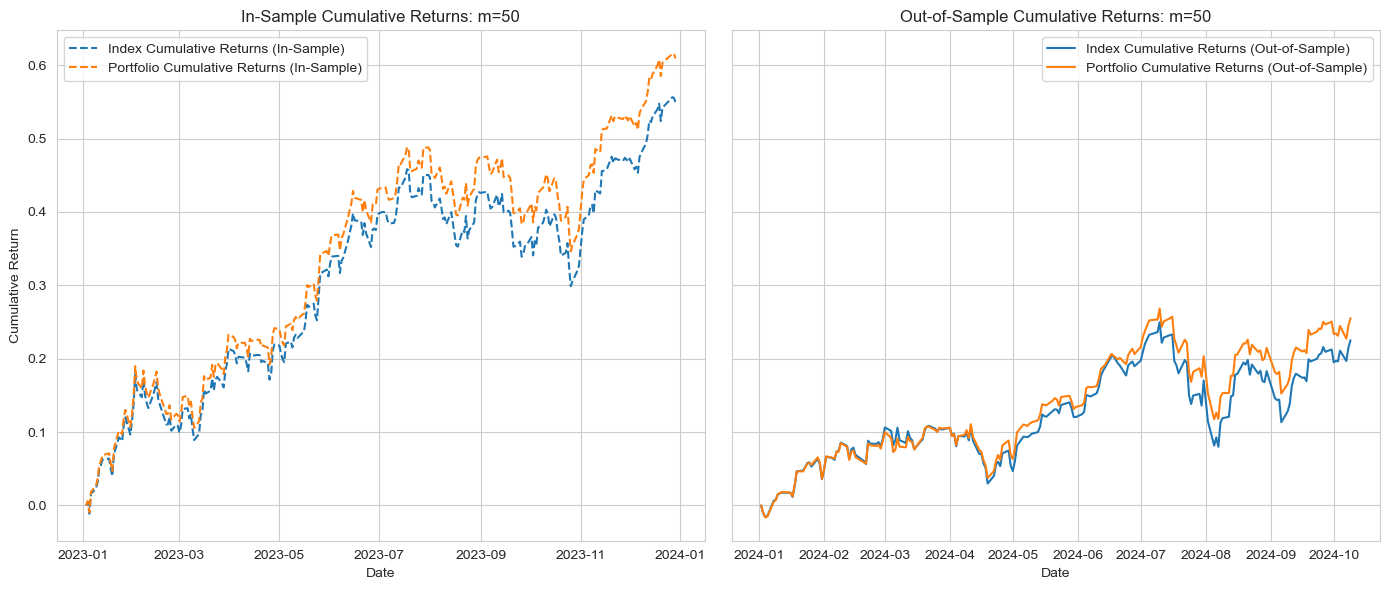

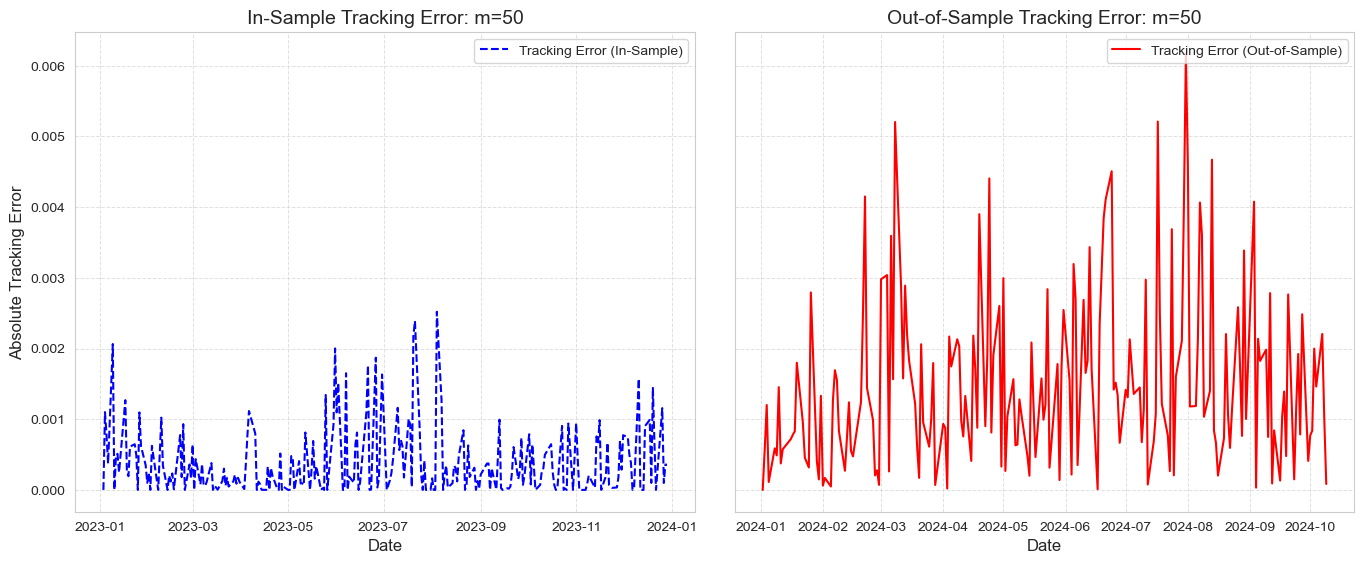

Processing for m = 60


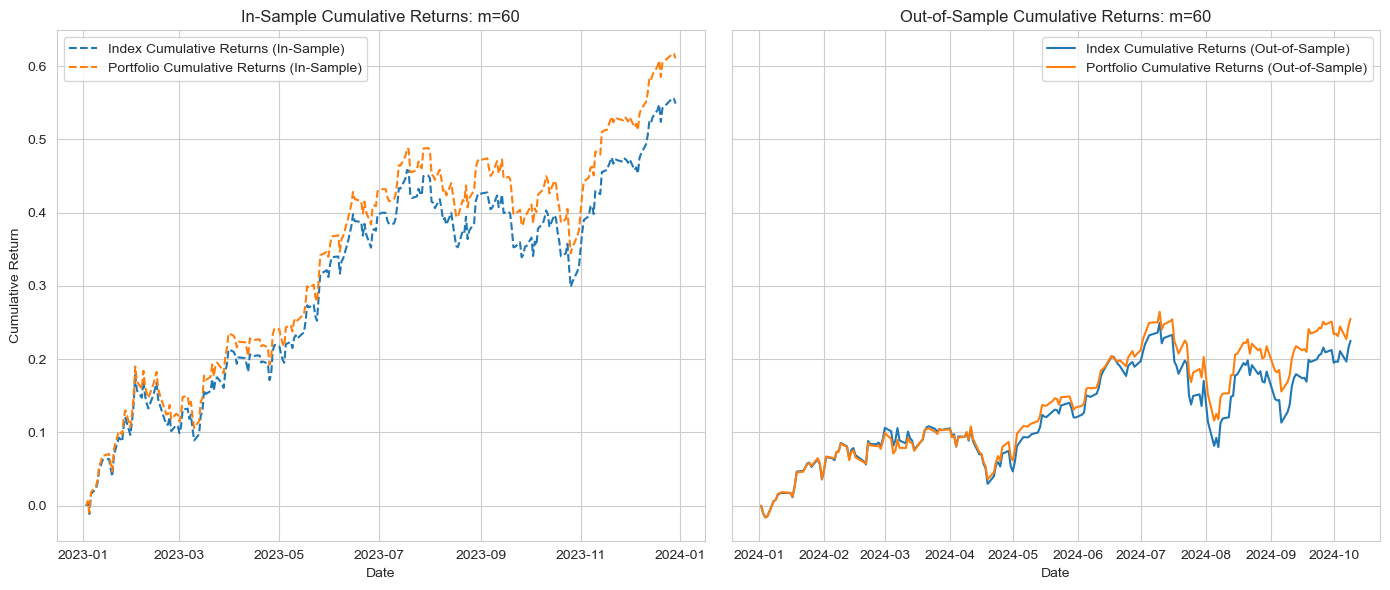

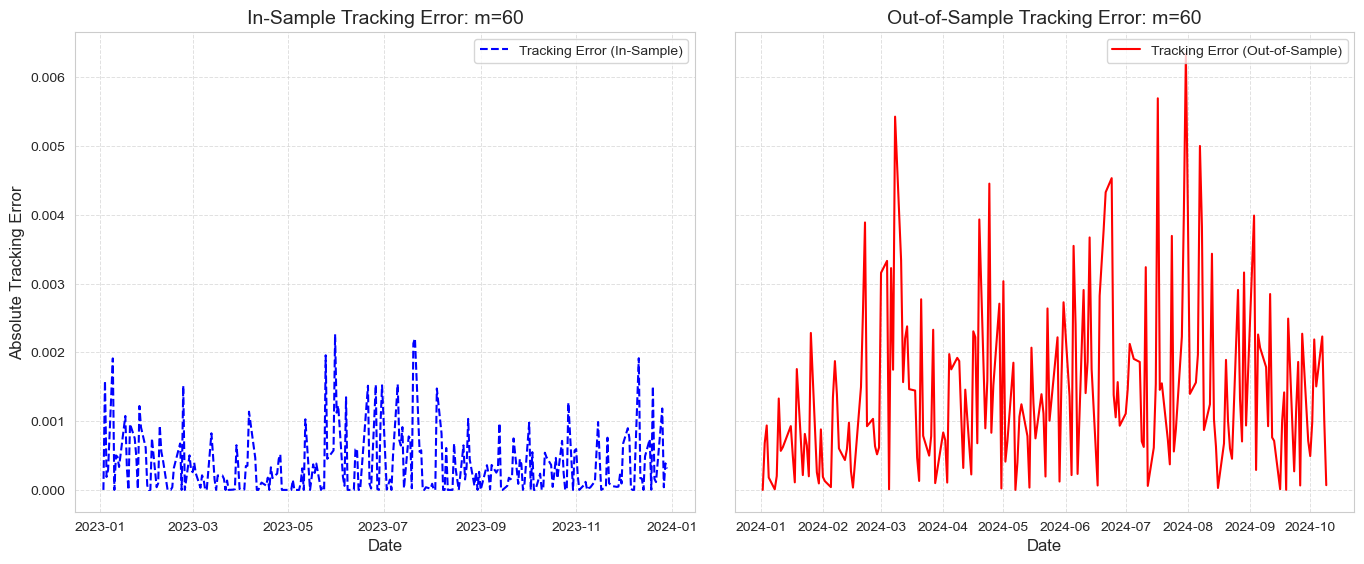

Processing for m = 70


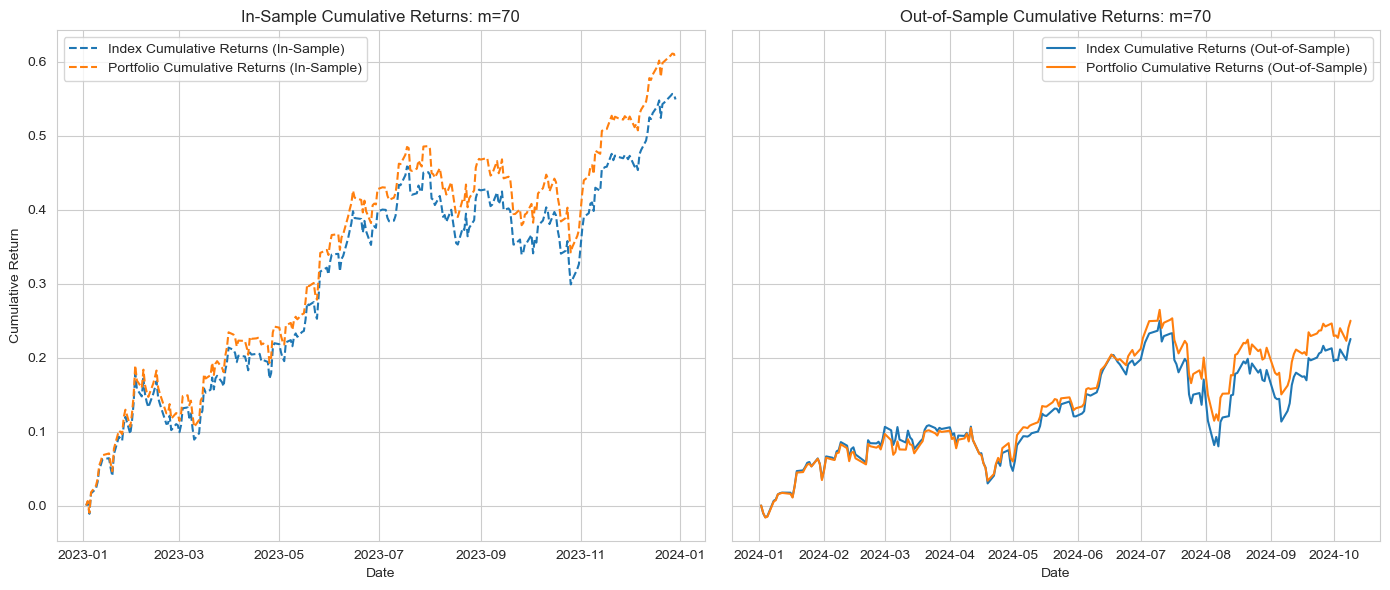

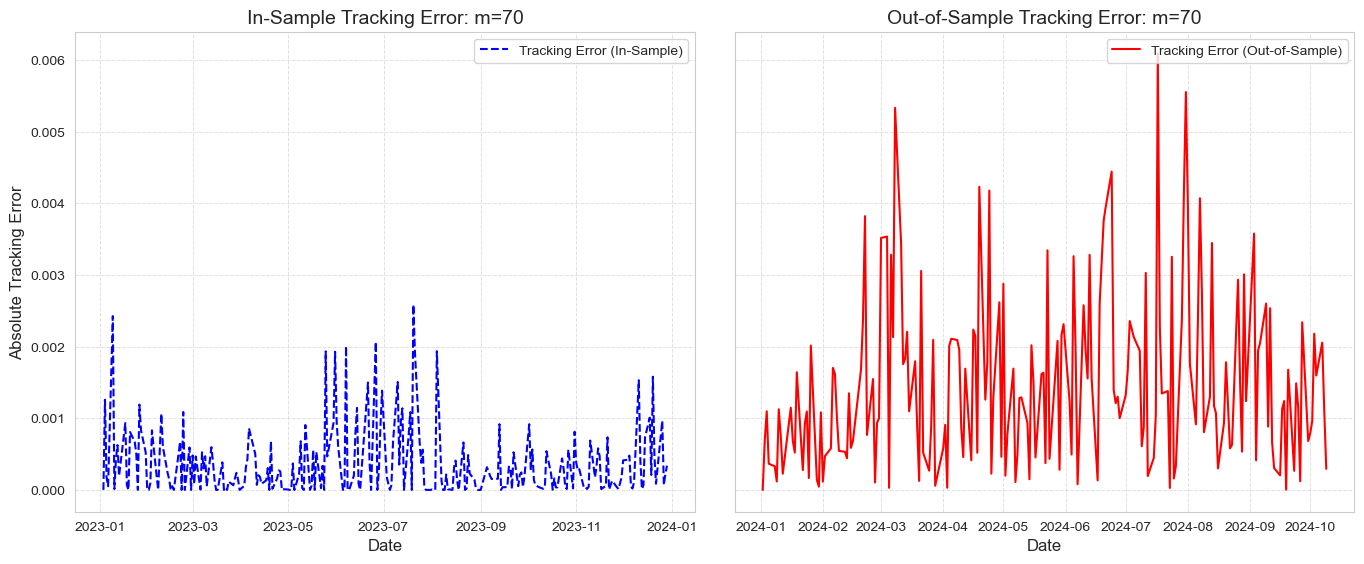

Processing for m = 80


Processing for m = 90


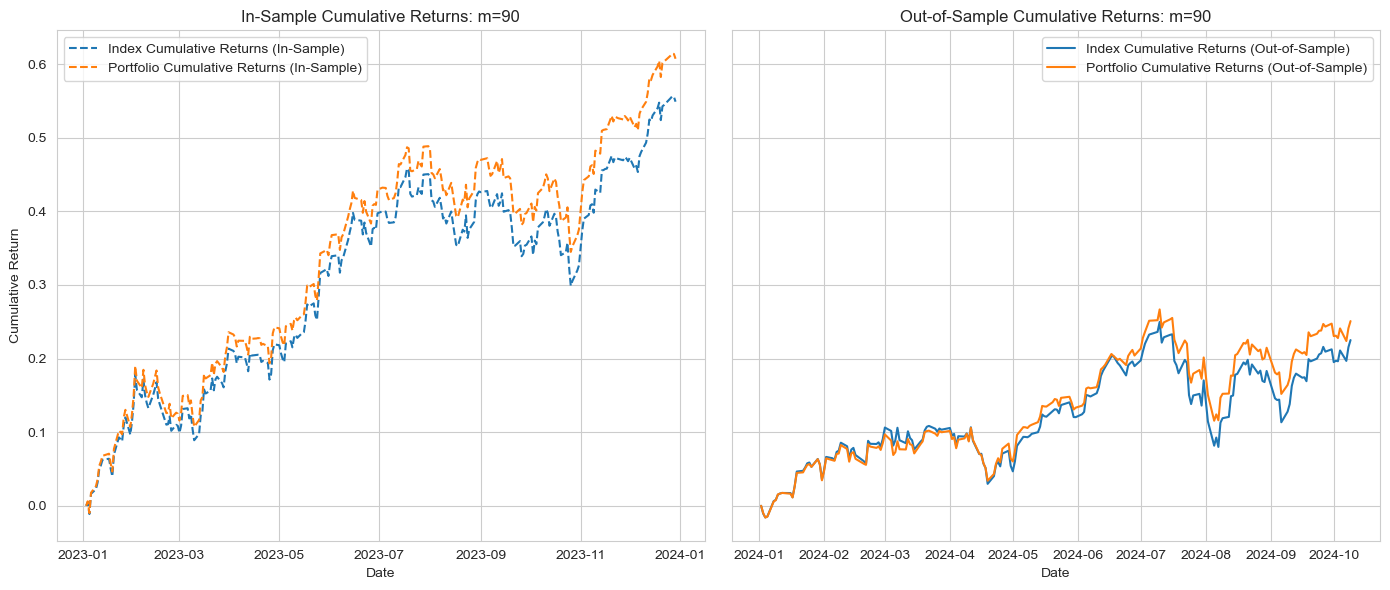

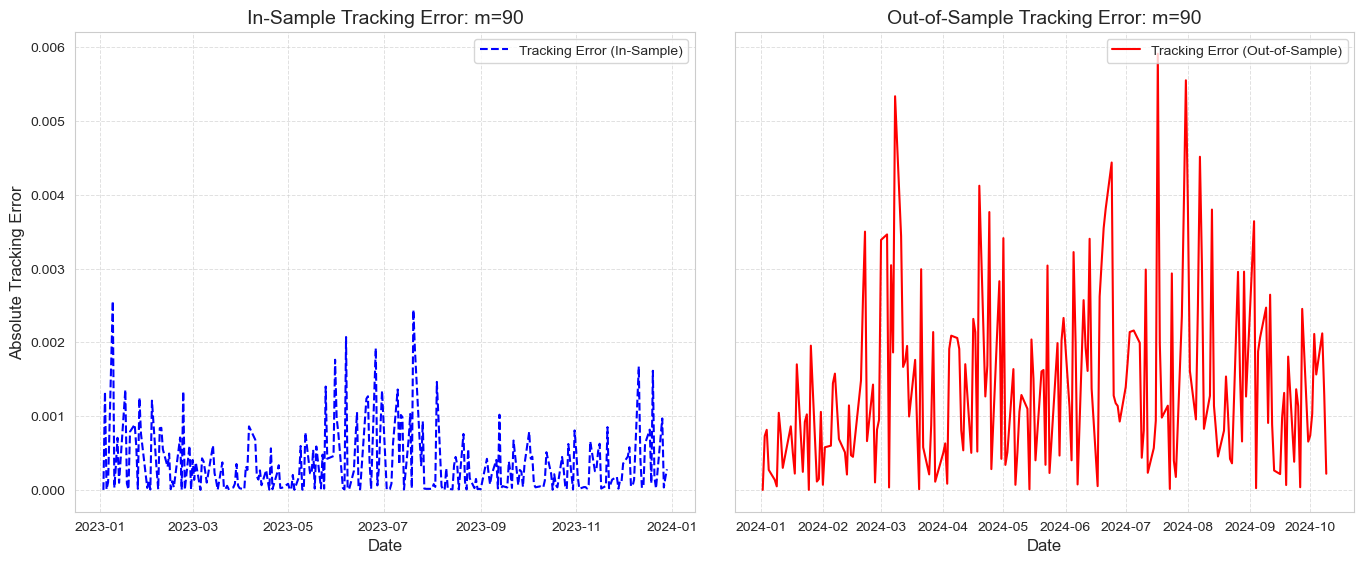

Processing for m = 100


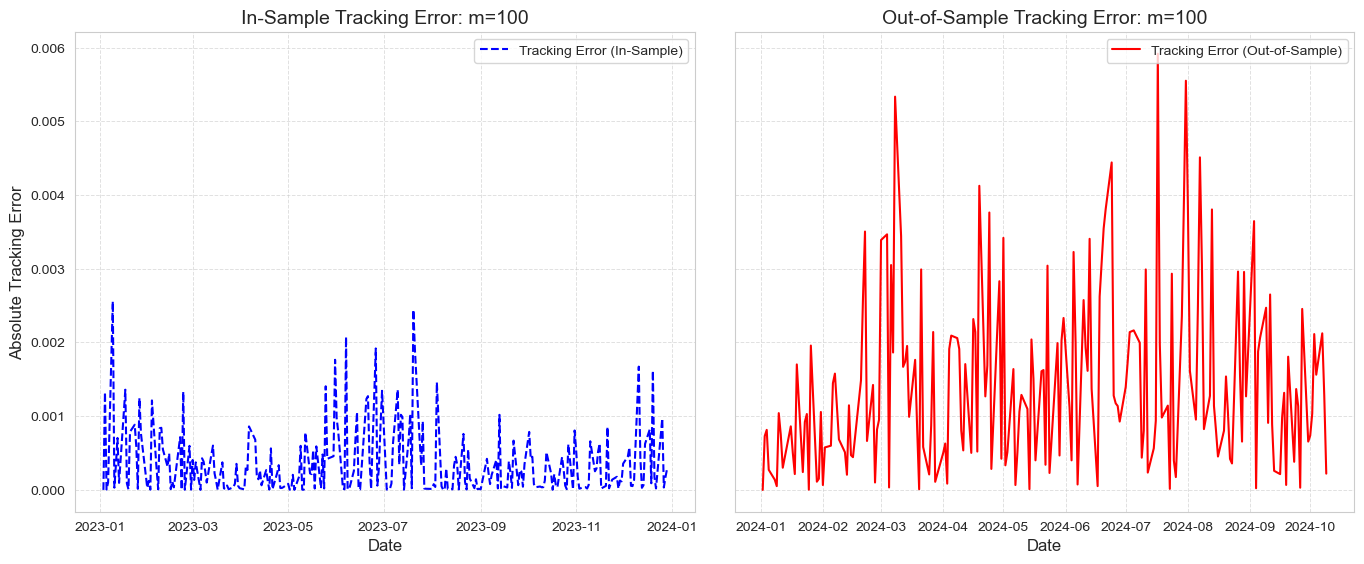

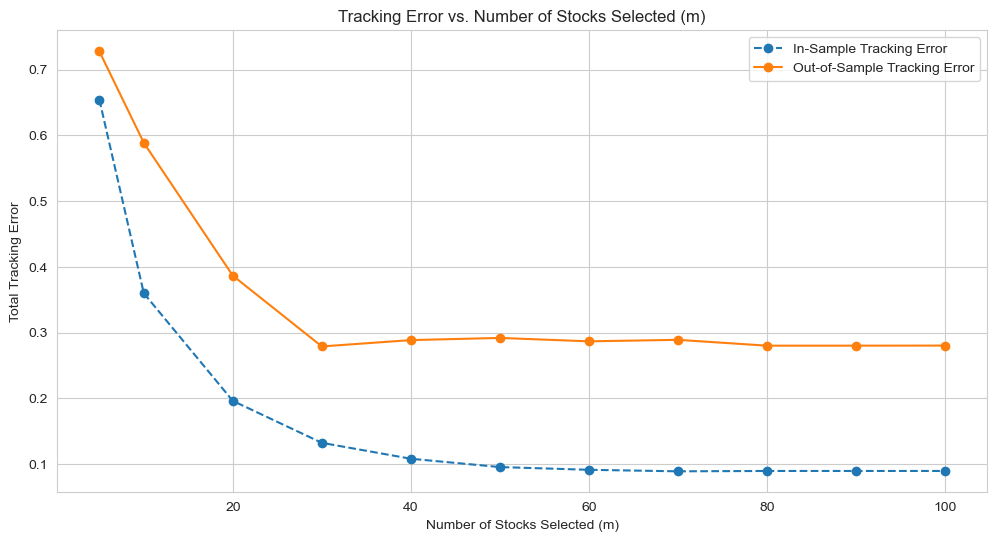

      m  In-Sample Tracking Error  Out-of-Sample Tracking Error
0     5                  0.654442                      0.727812
1    10                  0.359938                      0.588651
2    20                  0.196353                      0.386717
3    30                  0.132593                      0.279135
4    40                  0.108403                      0.288768
5    50                  0.095768                      0.292084
6    60                  0.091592                      0.286881
7    70                  0.089284                      0.289187
8    80                  0.089816                      0.280314
9    90                  0.089816                      0.280314
10  100                  0.089828                      0.280441


In [ ]:
method_2_tracking_errors_out_of_sample = Method2(file_path_2023,file_path_2024,m_list)

In [18]:
method_1_tracking_errors_out_of_sample

[1.023837071630218,
 0.7447489988869513,
 0.6236502416291256,
 0.6115263819348905,
 0.6056322004640644,
 0.5871494175913159,
 0.5722510472153611,
 0.5287771607899838,
 0.3725330455623076,
 0.30306577120514366,
 0.2770311608995886]

In [19]:
method_2_tracking_errors_out_of_sample

[0.7278119373909508,
 0.5886510381762373,
 0.38671732482158205,
 0.2791351168659055,
 0.288767876049748,
 0.29208391964150915,
 0.28688112179777403,
 0.2891867116102846,
 0.2803141179947114,
 0.28031411799471173,
 0.2804407361935909]

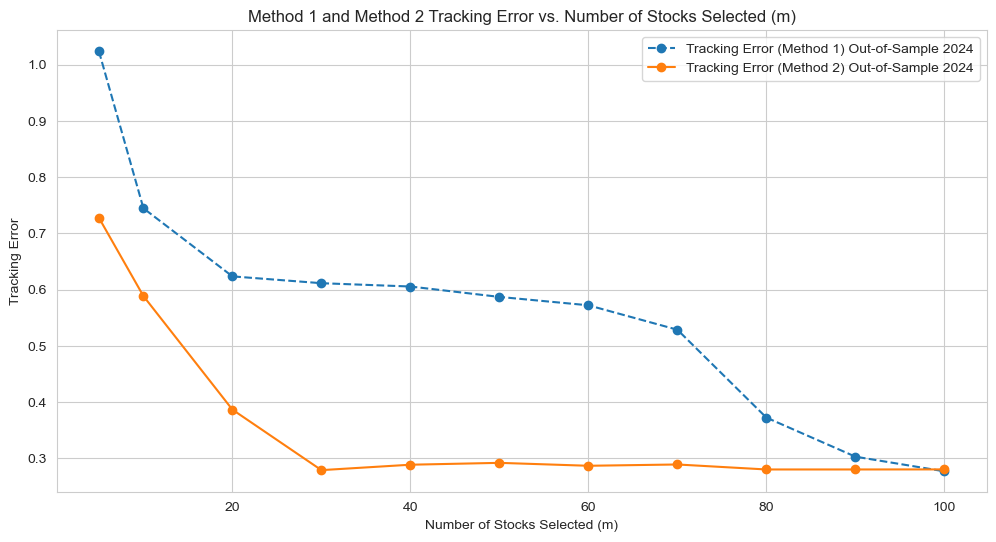

In [ ]:
def plot_error_vs_m(m_values, tracking_errors_1, tracking_errors_2):
    """
    Plot tracking error against different values of m for both out-sample and out-of-sample.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(m_values, tracking_errors_1, marker='o', label='Tracking Error (Method 1) Out-of-Sample 2024', linestyle='--')
    plt.plot(m_values, tracking_errors_2, marker='o', label='Tracking Error (Method 2) Out-of-Sample 2024', linestyle='-')
    plt.title('Method 1 and Method 2 Tracking Error vs. Number of Stocks Selected (m)')
    plt.xlabel('Number of Stocks Selected (m)')
    plt.ylabel('Tracking Error')
    plt.legend()
    plt.show()
plot_error_vs_m(m_list, method_1_tracking_errors_out_of_sample, method_2_tracking_errors_out_of_sample)